In [1]:
import certifi
import folium
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
import seaborn as sns
import ssl
import urllib.request

from IPython.display import display, HTML, IFrame, Markdown
from scipy.cluster.hierarchy import dendrogram, fcluster
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor

import fastcluster

# Introduction

Les données DVF recensent les transactions immobilières qui ont eu lieu au cours des cinq dernières années, à l'exception de l'Alsace, de la Moselle et de Mayotte. Ces informations sont issues des actes notariés et des informations cadastrales et sont disponibles en OpenData. Dans ce projet, nous appliquerons des méthodes de Machine Learning (ML) pour extraire des informations pertinentes de ces données.

Le travail que nous entreprendrons se divise en plusieurs phases. Tout d'abord, nous devons préparer nos données pour le ML. Cette étape comprend la fusion de jeux de données, la sélection de sous-ensembles de données, le calcul de nouveaux attributs, le tri des données pour la modélisation, l'élimination ou le remplacement des valeurs manquantes et la division des données en sous-ensembles d'apprentissage et de test.

Ensuite, nous effectuerons une analyse exploratoire des données (EDA) pour comprendre nos données et identifier les variables clés. Nous utiliserons des graphiques et des statistiques pour examiner la distribution, la plage de valeurs, le type et la signification des variables. Nous examinerons également la relation entre les variables caractéristiques et la variable cible. En plus, nous construirons une matrice de corrélation pour identifier les relations significatives entre les variables.

Nous appliquerons ensuite deux types d'apprentissage de ML à nos données : l'apprentissage non supervisé et l'apprentissage supervisé. Dans l'apprentissage non supervisé, nous modéliserons les données selon un algorithme ML non supervisé et interpréterons les clusters obtenus. Pour l'apprentissage supervisé, nous concentrerons notre travail sur les prix des appartements dans une région ou un département donné, et mettrons en place un modèle de prédiction des prix.

Ce travail est un effort de groupe et est destiné à fournir des informations et des prédictions pertinentes sur les tendances du marché immobilier à partir des données DVF. Nous espérons que vous trouverez les résultats de notre analyse aussi fascinants que nous avons trouvé le processus pour les obtenir.

# 1) Chargement des données brutes

In [2]:
LOAD_FROM_WEB = False

In [3]:
df_raw = None
if LOAD_FROM_WEB:
    urls = [
            "https://www.data.gouv.fr/fr/datasets/r/87038926-fb31-4959-b2ae-7a24321c599a",
            "https://www.data.gouv.fr/fr/datasets/r/817204ac-2202-4b4a-98e7-4184d154d98c",
            "https://www.data.gouv.fr/fr/datasets/r/90a98de0-f562-4328-aa16-fe0dd1dca60f",
            "https://www.data.gouv.fr/fr/datasets/r/3004168d-bec4-44d9-a781-ef16f41856a2",
            "https://www.data.gouv.fr/fr/datasets/r/1be77ca5-dc1b-4e50-af2b-0240147e0346"
        ]

    ctx = ssl.create_default_context(cafile=certifi.where())

    dfs = [] 

    for url in urls:
        with urllib.request.urlopen(url, context=ctx) as u:
            df_raw = pd.read_csv( 
                u,
                sep="|",
                parse_dates=["Date mutation"],
                date_format="%d/%m/%Y",
                decimal=",",
                low_memory=False,
                index_col="Date mutation",
            )
            dfs.append(df_raw)

    df_raw = pd.concat(dfs)
    df_raw.to_pickle('raw_2018-2022.pkl')
else:
    try:
        df_raw = pd.read_pickle('raw_2018-2022.pkl')
    except:
        print('Pas de fichier pikcle')
        
print('Success')

Success


In [4]:
pd.set_option('display.max_columns', None)
df_raw.head()

Identifiant de document  Reference document  1 Articles CGI  \
Date mutation                                                                
2022-01-03                         NaN                 NaN             NaN   
2022-01-03                         NaN                 NaN             NaN   
2022-01-03                         NaN                 NaN             NaN   
2022-01-03                         NaN                 NaN             NaN   
2022-01-04                         NaN                 NaN             NaN   

               2 Articles CGI  3 Articles CGI  4 Articles CGI  5 Articles CGI  \
Date mutation                                                                   
2022-01-03                NaN             NaN             NaN             NaN   
2022-01-03                NaN             NaN             NaN             NaN   
2022-01-03                NaN             NaN             NaN             NaN   
2022-01-03                NaN             NaN             NaN             NaN   
2022-01-04                NaN             NaN             NaN             NaN   

               No disposition Nature mutation  Valeur fonciere  No voie B/T/Q  \
Date mutation                                                                   
2022-01-03                  1           Vente          55000.0     13.0   NaN   
2022-01-03                  1           Vente         143000.0      NaN   NaN   
2022-01-03                  1           Vente         143000.0      NaN   NaN   
2022-01-03                  1           Vente         143000.0     98.0   NaN   
2022-01-04                  1           Vente            300.0      NaN   NaN   

              Type de voie Code voie           Voie  Code postal  \
Date mutation                                                      
2022-01-03             RUE      2280  DE LA LIBERTE       1000.0   
2022-01-03             NaN      B010   CHAMP COCHET       1480.0   
2022-01-03             NaN      B010   CHAMP COCHET       1480.0   
2022-01-03             RTE      0055   DE LA DOMBES       1480.0   
2022-01-04             NaN      B031    AUX PIERRES       1480.0   

                         Commune Code departement  Code commune  \
Date mutation                                                     
2022-01-03       BOURG-EN-BRESSE               01            53   
2022-01-03             SAVIGNEUX               01           398   
2022-01-03             SAVIGNEUX               01           398   
2022-01-03             SAVIGNEUX               01           398   
2022-01-04     MESSIMY SUR SAONE               01           243   

               Prefixe de section Section  No plan No Volume 1er lot  \
Date mutation                                                          
2022-01-03                    NaN      AM      102       NaN       7   
2022-01-03                    NaN      ZE      184       NaN     NaN   
2022-01-03                    NaN      ZE      185       NaN     NaN   
2022-01-03                    NaN      ZE      187       NaN       1   
2022-01-04                    NaN       A      643       NaN     NaN   

               Surface Carrez du 1er lot 2eme lot  Surface Carrez du 2eme lot  \
Date mutation                                                                   
2022-01-03                         24.10      NaN                         NaN   
2022-01-03                           NaN      NaN                         NaN   
2022-01-03                           NaN      NaN                         NaN   
2022-01-03                        123.23      NaN                         NaN   
2022-01-04                           NaN      NaN                         NaN   

              3eme lot  Surface Carrez du 3eme lot 4eme lot  \
Date mutation                                                 
2022-01-03         NaN                         NaN      NaN   
2022-01-03         NaN                         NaN      NaN   
2022-01-03         NaN                         NaN      NaN 

In [5]:
df_raw.shape

(18928987, 42)

19 millions de demandes de valeurs foncières avec 42 variables.

---
#  2) préparation des données

Cette phase  comporte généralement les tâches
suivantes :
- Fusion des ensembles et/ou enregistrements de données
- Sélection d’un sous-ensemble de données
- Suppression ou remplacement des blancs ou des valeurs manquantes
- Calcul de nouveaux attributs
- Modifications des types des variables
- Tri des données en vue de la modélisation

## 2.1) Fusion des ensembles des differentes années

Pour le moment vide car la fusion se fais dans le chargement des données

## 2.2) Sélection d’un sous-ensemble de données : Appartements et Maisons

In [6]:
df_raw['Type local'].unique().tolist()

['Appartement',
 nan,
 'Maison',
 'Local industriel. commercial ou assimilé',
 'Dépendance']

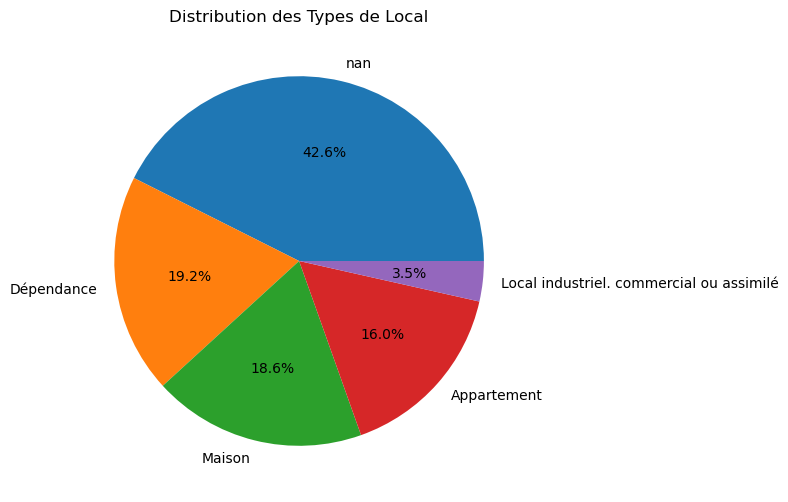

In [7]:
type_counts = df_raw['Type local'].value_counts(dropna = False)

plt.figure(figsize=(10, 6))
plt.pie(type_counts, labels = type_counts.index, autopct='%1.1f%%')
plt.title('Distribution des Types de Local')
plt.show()

On ne garde que les appartements et les maisons

In [8]:
df = df_raw[ df_raw['Type local'].isin(['Maison', 'Appartement']) ]

In [9]:
df.shape

(6564977, 42)

On a 6.5 millions de demandes de valeurs foncières concernant une maison ou un appartement.

## 2.3) Suppression ou remplacement des blancs ou des valeurs manquantes

### 2.3.1) Suppression des variables possedant un taux de valeurs manquantes trop importantes

In [10]:
taux_valeurs_manquantes = df.isnull().sum()/len(df)*100
taux_valeurs_manquantes

Identifiant de document       100.000000
Reference document            100.000000
1 Articles CGI                100.000000
2 Articles CGI                100.000000
3 Articles CGI                100.000000
4 Articles CGI                100.000000
5 Articles CGI                100.000000
No disposition                  0.000000
Nature mutation                 0.000000
Valeur fonciere                 0.569141
No voie                         1.391490
B/T/Q                          93.258590
Type de voie                   12.054071
Code voie                       0.000000
Voie                            0.001538
Code postal                     0.004737
Commune                         0.000000
Code departement                0.000000
Code commune                    0.000000
Prefixe de section             95.753588
Section                         0.003884
No plan                         0.000000
No Volume                     100.000000
1er lot                        62.506967
Surface Carrez d

Nous constatons que la base brute contient beaucoup de variables qui ont un taux de plus de 80% des données manquantes. <br> Nous allons donc exclure ces variables.

In [11]:
taux_valeurs_manquantes[ taux_valeurs_manquantes >= 80].index.tolist()

['Identifiant de document',
 'Reference document',
 '1 Articles CGI',
 '2 Articles CGI',
 '3 Articles CGI',
 '4 Articles CGI',
 '5 Articles CGI',
 'B/T/Q',
 'Prefixe de section',
 'No Volume',
 'Surface Carrez du 1er lot',
 '2eme lot',
 'Surface Carrez du 2eme lot',
 '3eme lot',
 'Surface Carrez du 3eme lot',
 '4eme lot',
 'Surface Carrez du 4eme lot',
 '5eme lot',
 'Surface Carrez du 5eme lot',
 'Identifiant local',
 'Nature culture speciale']

In [12]:
df = df.drop(['Identifiant de document',
              'Reference document',
              '1 Articles CGI',
              '2 Articles CGI',
              '3 Articles CGI',
              '4 Articles CGI',
              '5 Articles CGI',
              'B/T/Q',
              'Prefixe de section',
              'No Volume',
              '1er lot',
              'Surface Carrez du 1er lot',
              '2eme lot',
              'Surface Carrez du 2eme lot',
              '3eme lot',
              'Surface Carrez du 3eme lot',
              '4eme lot',
              'Surface Carrez du 4eme lot',
              '5eme lot',
              'Surface Carrez du 5eme lot',
              'Identifiant local',
              'Nature culture speciale']
, axis=1)

### 2.3.2) Suppression des variables geographiques inutiles a l'analyse

In [13]:
variables_geo_non_pertinente = ['Code voie', 'No voie', 'Voie', 'Section', 'No plan']
df = df.drop(variables_geo_non_pertinente, axis=1)

### 2.3.3) Suppression des autres variables inutiles a l'analyse 

In [14]:
autres_variables = ['No disposition', 'Code type local', 'Code commune']
df.drop(autres_variables, axis=1, inplace=True)

### 2.3.4) Suppresion des enregistrements sans surface reelle bati et nombre de pieces principales

In [15]:
df[['Nombre pieces principales', 'Surface reelle bati']].isnull().sum()/len(df)*100

Nombre pieces principales    0.003244
Surface reelle bati          0.003244
dtype: float64

Il manque ces deux variables dans moins de 0.1% des demandes de valeurs foncières. <br>
Nous allons donc exclure ces demandes de valeurs foncières.

In [16]:
df.dropna(subset=['Surface reelle bati'], inplace=True)

In [17]:
df[['Nombre pieces principales', 'Surface reelle bati']].isnull().sum()/len(df)*100

Nombre pieces principales    0.0
Surface reelle bati          0.0
dtype: float64

### 2.3.5) Suprression des enregistrements sans valeur foncière

In [18]:
df['Valeur fonciere'].isnull().sum()/len(df)*100

0.5691598357534254

Il manque la valeur fonciere dans moins de 0.5% des demandes de valeurs foncières. <br>
Nous allons donc les exclure.

In [19]:
df.dropna(subset=['Valeur fonciere'], inplace=True)

## 2.3) Calcul de nouveaux attributs

### 2.3.1) Calcul du prix au mètre carré

In [20]:
df['Prix au metre carre'] = df['Valeur fonciere'] / df['Surface reelle bati']
# Correction pour éviter la division par zéro
df['Prix au metre carre'] = df['Prix au metre carre'].where(df['Surface reelle bati'] != 0, 0)

### 2.3.2) Calcul des regions

In [21]:
REGIONS = {
    'Auvergne-Rhône-Alpes': ['01', '03', '07', '15', '26', '38', '42', '43', '63', '69', '73', '74'],
    'Bourgogne-Franche-Comté': ['21', '25', '39', '58', '70', '71', '89', '90'],
    'Bretagne': ['35', '22', '56', '29'],
    'Centre-Val de Loire': ['18', '28', '36', '37', '41', '45'],
    'Corse': ['2A', '2B'],
    'Grand Est': ['08', '10', '51', '52', '54', '55', '57', '67', '68', '88'],
    'Guadeloupe': ['971'],
    'Guyane': ['973'],
    'Hauts-de-France': ['02', '59', '60', '62', '80'],
    'Île-de-France': ['75', '77', '78', '91', '92', '93', '94', '95'],
    'La Réunion': ['974'],
    'Martinique': ['972'],
    'Normandie': ['14', '27', '50', '61', '76'],
    'Nouvelle-Aquitaine': ['16', '17', '19', '23', '24', '33', '40', '47', '64', '79', '86', '87'],
    'Occitanie': ['09', '11', '12', '30', '31', '32', '34', '46', '48', '65', '66', '81', '82'],
    'Pays de la Loire': ['44', '49', '53', '72', '85'],
    'Provence-Alpes-Côte d\'Azur': ['04', '05', '06', '13', '83', '84'],
}

In [22]:
DEPARTEMENT_TO_REGION = {code: region for region, codes in REGIONS.items() for code in codes}

df['Region'] = df['Code departement'].map(DEPARTEMENT_TO_REGION)

### 2.3.3) Calcul des departements

In [23]:
DEPARTEMENTS = {
    '01': 'Ain', 
    '02': 'Aisne', 
    '03': 'Allier', 
    '04': 'Alpes-de-Haute-Provence', 
    '05': 'Hautes-Alpes',
    '06': 'Alpes-Maritimes', 
    '07': 'Ardèche', 
    '08': 'Ardennes', 
    '09': 'Ariège', 
    '10': 'Aube', 
    '11': 'Aude',
    '12': 'Aveyron', 
    '13': 'Bouches-du-Rhône', 
    '14': 'Calvados', 
    '15': 'Cantal', 
    '16': 'Charente',
    '17': 'Charente-Maritime', 
    '18': 'Cher', 
    '19': 'Corrèze', 
    '2A': 'Corse-du-Sud', 
    '2B': 'Haute-Corse',
    '21': 'Côte-d\'Or', 
    '22': 'Côtes-d\'Armor', 
    '23': 'Creuse', 
    '24': 'Dordogne', 
    '25': 'Doubs', 
    '26': 'Drôme',
    '27': 'Eure', 
    '28': 'Eure-et-Loir', 
    '29': 'Finistère', 
    '30': 'Gard', 
    '31': 'Haute-Garonne', 
    '32': 'Gers',
    '33': 'Gironde', 
    '34': 'Hérault', 
    '35': 'Ille-et-Vilaine', 
    '36': 'Indre', 
    '37': 'Indre-et-Loire',
    '38': 'Isère', 
    '39': 'Jura', 
    '40': 'Landes', 
    '41': 'Loir-et-Cher', 
    '42': 'Loire', 
    '43': 'Haute-Loire',
    '44': 'Loire-Atlantique', 
    '45': 'Loiret', 
    '46': 'Lot', 
    '47': 'Lot-et-Garonne', 
    '48': 'Lozère',
    '49': 'Maine-et-Loire', 
    '50': 'Manche', 
    '51': 'Marne', 
    '52': 'Haute-Marne', 
    '53': 'Mayenne',
    '54': 'Meurthe-et-Moselle', 
    '55': 'Meuse', 
    '56': 'Morbihan', 
    '57': 'Moselle', 
    '58': 'Nièvre', 
    '59': 'Nord',
    '60': 'Oise', 
    '61': 'Orne', 
    '62': 'Pas-de-Calais', 
    '63': 'Puy-de-Dôme', 
    '64': 'Pyrénées-Atlantiques',
    '65': 'Hautes-Pyrénées', 
    '66': 'Pyrénées-Orientales', 
    '67': 'Bas-Rhin', 
    '68': 'Haut-Rhin', 
    '69': 'Rhône',
    '70': 'Haute-Saône', 
    '71': 'Saône-et-Loire', 
    '72': 'Sarthe', 
    '73': 'Savoie', 
    '74': 'Haute-Savoie',
    '75': 'Paris', 
    '76': 'Seine-Maritime', 
    '77': 'Seine-et-Marne', 
    '78': 'Yvelines', 
    '79': 'Deux-Sèvres',
    '80': 'Somme', 
    '81': 'Tarn', 
    '82': 'Tarn-et-Garonne', 
    '83': 'Var', 
    '84': 'Vaucluse', 
    '85': 'Vendée',
    '86': 'Vienne', 
    '87': 'Haute-Vienne', 
    '88': 'Vosges', 
    '89': 'Yonne', 
    '90': 'Territoire de Belfort',
    '91': 'Essonne', 
    '92': 'Hauts-de-Seine', 
    '93': 'Seine-Saint-Denis', 
    '94': 'Val-de-Marne', 
    '95': 'Val-d\'Oise',
    '971': 'Guadeloupe', 
    '972': 'Martinique', 
    '973': 'Guyane', 
    '974': 'La Réunion', 
    '976': 'Mayotte',
}

In [24]:
df['Departement'] = df['Code departement'].map(DEPARTEMENTS)

## 2.4) Modification des types des variables

In [25]:
df['Code postal'] = df['Code postal'].astype('object')
df['Nombre pieces principales'] = df ['Nombre pieces principales'].astype('int')

## 2.5) Donnees pour l'analyse exploratoire des données
Nous utiliserons ce dataframe pour l'analyse exploratoire des données

In [26]:
df.isna().sum()/len(df)*100

Nature mutation               0.000000
Valeur fonciere               0.000000
Type de voie                 12.078423
Code postal                   0.004719
Commune                       0.000000
Code departement              0.000000
Nombre de lots                0.000000
Type local                    0.000000
Surface reelle bati           0.000000
Nombre pieces principales     0.000000
Nature culture               38.145280
Surface terrain              38.145280
Prix au metre carre           0.000000
Region                        0.000000
Departement                   0.000000
dtype: float64

## 2.6) Tri des données en vue de la modelisation : Ile-de-France

In [27]:
df_model = df.dropna(subset=['Surface terrain'])

In [28]:
df_model['Type local'].unique()

array(['Maison', 'Appartement'], dtype=object)

In [29]:
df_model = df_model[ df_model['Type local'] == 'Appartement']

In [30]:
df_model['Region'].value_counts()

Region
Île-de-France                 111522
Auvergne-Rhône-Alpes           89828
Occitanie                      70812
Nouvelle-Aquitaine             64696
Hauts-de-France                58323
Provence-Alpes-Côte d'Azur     56068
Bourgogne-Franche-Comté        42978
Grand Est                      40747
Normandie                      34375
Bretagne                       28744
Pays de la Loire               25051
Centre-Val de Loire            21050
La Réunion                     13342
Martinique                      5458
Guyane                          3260
Guadeloupe                      3118
Corse                           1604
Name: count, dtype: int64

La region pour laquelle nous avons le plus de demandes de valeurs foncières est l'Île-de-France. 
Nous choisissons de modeliser les demandes de valeurs foncières de l'Île-de-France.

In [31]:
df_model = df_model[ df_model['Region'] == 'Île-de-France']
df_model.shape

(111522, 15)

Nous travaillerons sur 111 milles demandes de valeurs foncières

In [32]:
df_model = df_model.drop(['Code postal',
                          'Commune',
                          'Departement',
                          'Code departement',
                          'Type local',
                          'Prix au metre carre',
                          'Region',
                          'Nature culture'
                         ], axis=1)

In [33]:
df_model.columns.tolist()

['Nature mutation',
 'Valeur fonciere',
 'Type de voie',
 'Nombre de lots',
 'Surface reelle bati',
 'Nombre pieces principales',
 'Surface terrain']

## 2.7) Division des données de modélisation en un ensemble d'entrainement et de test

In [34]:
X_train, X_test, y_train, y_test = train_test_split(df_model.drop('Valeur fonciere', axis=1), df_model['Valeur fonciere'], test_size=0.2, random_state=42)

---
# 3) Analyse exploratoire des données

Cette phase consiste à :
1. Identifier la variable cible qui doit être prédite.
2. Effectuer une analyse exploratoire des données (EDA, Exploratory Data Analysis) par une
variété de graphiques et de statistiques en suivant les étapes suivantes :
- Faire un aperçu des variables en examinant leur type, leur distribution, leur plage de
valeurs et leur signification.
- Examiner la relation entre les variables caractéristiques et la variable cible en utilisant
des techniques graphiques telles que des histogrammes, des diagrammes en boîte et
des graphiques de dispersion
- Construire une matrice de corrélation entre les variables
- Interpréter les résultats de l’EDA pour identifier les caractéristiques importantes qui
influencent le prix du mètre carré et les relations significatives entre les variables
Nous serons attentifs sur:
- Une dizaine d'interprétations et visualisations pertinentes autour d'une année (en
particulier 2022 ) prix moyen du mètre carré d'un département d'une ville, comparaison
entre différents types, appart, maison, geomap, différence entre ville, départements,
régions,...
- En bonus, quelques interprétations et visualisations pertinentes en comparaison avec au
moins une autre année (en particulier avant covid)


In [35]:
df.columns.tolist()

['Nature mutation',
 'Valeur fonciere',
 'Type de voie',
 'Code postal',
 'Commune',
 'Code departement',
 'Nombre de lots',
 'Type local',
 'Surface reelle bati',
 'Nombre pieces principales',
 'Nature culture',
 'Surface terrain',
 'Prix au metre carre',
 'Region',
 'Departement']

## 1) Analyse de la variable cible: valeur foncière

In [36]:
# Affiche un diagramme moustache et un histogramme pour une variable
def plot_boxplot_histogram(df, column, comment=None):    
    column_copy = df[column].copy().dropna()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Boxplot
    ax1.boxplot(column_copy)
    ax1.set_ylabel(column)
    ax1.set_title('Boxplot')

    # Histogramme
    ax2.hist(column_copy, bins=30)
    ax2.set_xlabel(column)
    ax2.set_ylabel('Fréquence')
    ax2.set_title('Histogramme')

    title = column
    if comment:
        title += ' - ' + comment
        
    plt.suptitle(title, fontsize=17)
    plt.tight_layout()
    plt.show()

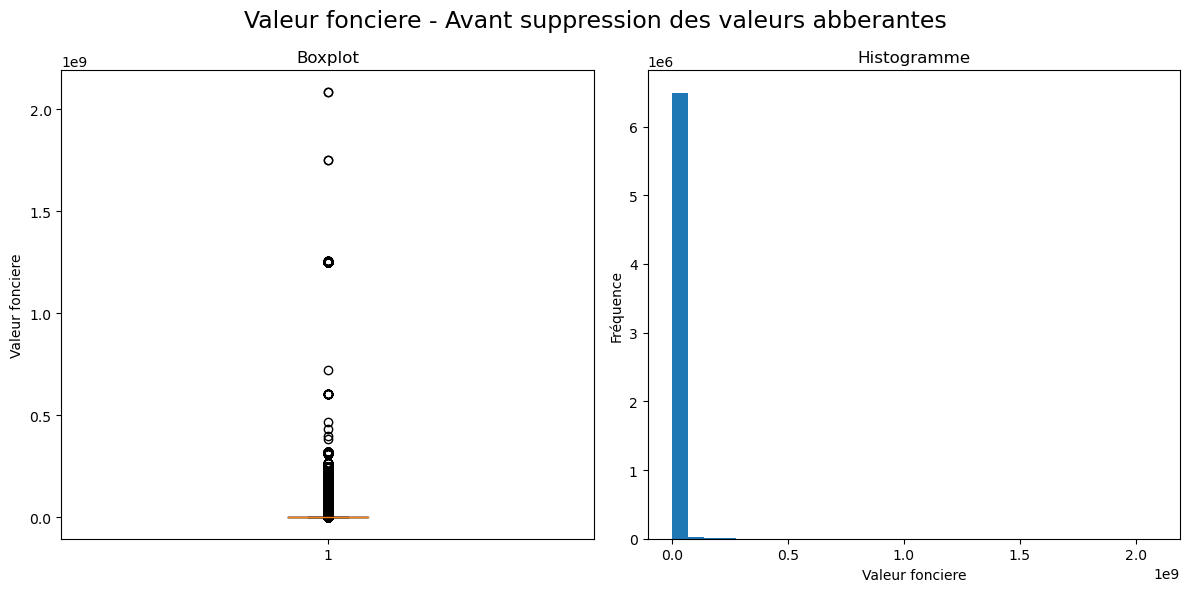

In [37]:
plot_boxplot_histogram(df, 'Valeur fonciere', comment='Avant suppression des valeurs abberantes')

### 1.1) Suppression des valeurs abberantes de la variable valeur fonciere

In [38]:
def remove_outliers_iqr(df, column):
    # Calculating the IQR
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Removing outliers
    df_filtered = df[~((df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR)))]

    return df_filtered

In [39]:
df_filtered = remove_outliers_iqr(df, 'Valeur fonciere')

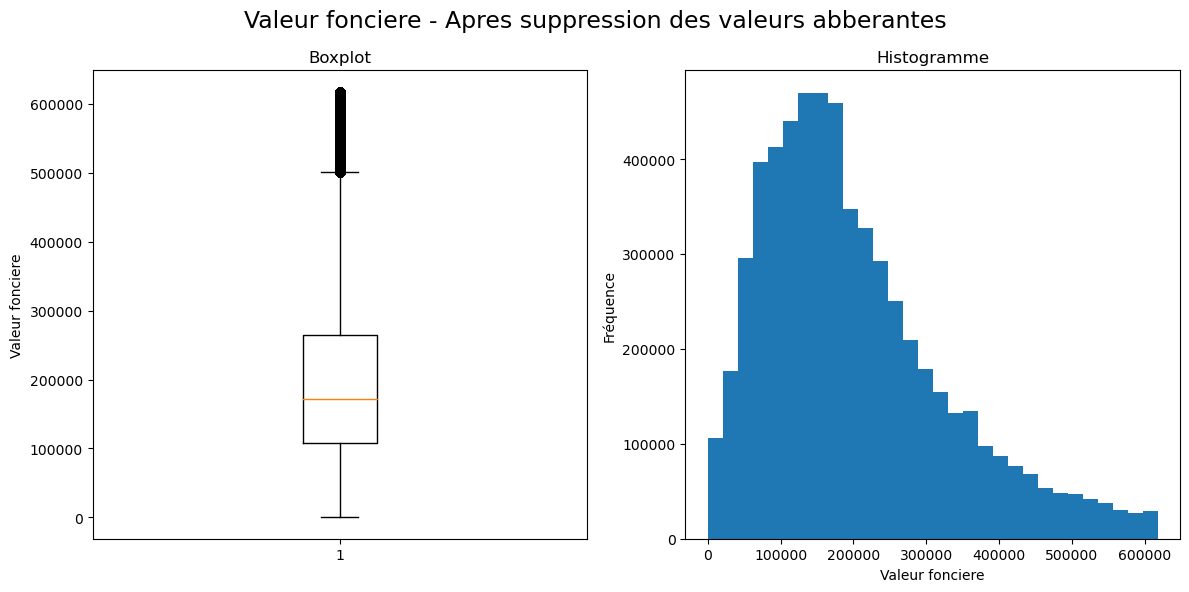

In [40]:
plot_boxplot_histogram(df_filtered, 'Valeur fonciere', comment='Apres suppression des valeurs abberantes')

In [41]:
df_filtered.describe()

Valeur fonciere  Nombre de lots  Surface reelle bati  \
count     5.899909e+06    5.899909e+06         5.899909e+06   
mean      2.002618e+05    5.769326e-01         8.080219e+01   
std       1.263406e+05    8.550588e-01         4.319498e+01   
min       1.500000e-01    0.000000e+00         0.000000e+00   
25%       1.075000e+05    0.000000e+00         5.000000e+01   
50%       1.720000e+05    0.000000e+00         7.500000e+01   
75%       2.650000e+05    1.000000e+00         1.010000e+02   
max       6.175000e+05    3.000000e+01         2.426000e+03   

       Nombre pieces principales  Surface terrain  Prix au metre carre  
count               5.899909e+06     3.585974e+06         5.899909e+06  
mean                3.455381e+00     8.521959e+02         3.097722e+03  
std                 1.570988e+00     3.655173e+03         3.907229e+03  
min                 0.000000e+00     0.000000e+00         0.000000e+00  
25%                 2.000000e+00     2.490000e+02         1.470588e+03  
50%                 3.000000e+00     5.000000e+02         2.314286e+03  
75%                 4.000000e+00     8.300000e+02         3.650000e+03  
max                 1.090000e+02     3.760000e+06         6.138502e+05

## 2.2) Aperçu des variables

### 2.2.1) Variables quantitatives

In [42]:
df_ = df_filtered.copy()

### Surface reelle bati

In [43]:
surface_reelle_bati_dtype = df_filtered['Surface reelle bati'].dtype
print("Type de données : ", surface_reelle_bati_dtype)

Type de données :  float64


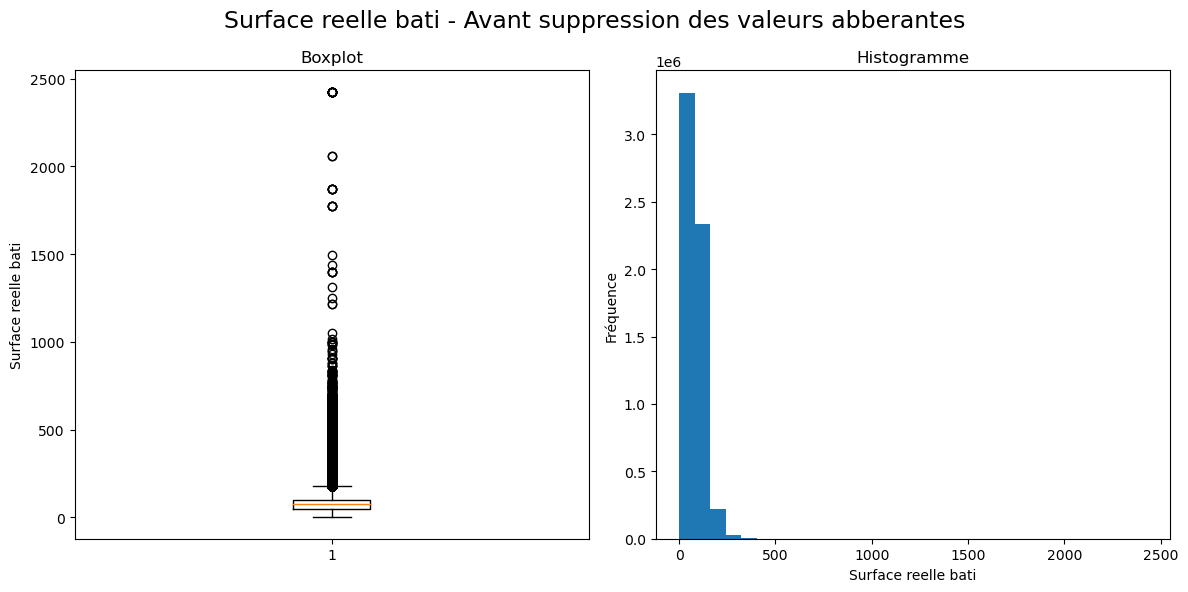

In [44]:
plot_boxplot_histogram(df_filtered, 'Surface reelle bati', 'Avant suppression des valeurs abberantes')

In [45]:
df_filtered = remove_outliers_iqr(df_filtered, 'Surface reelle bati')

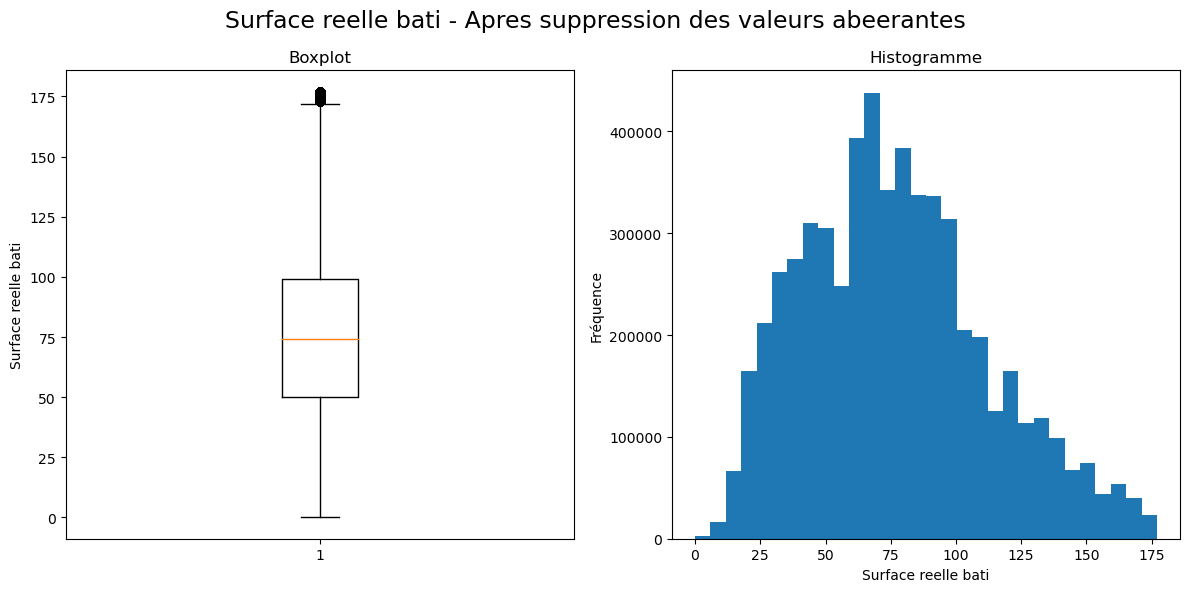

In [46]:
plot_boxplot_histogram(df_filtered, 'Surface reelle bati', 'Apres suppression des valeurs abberantes')

In [47]:
min_value = df_filtered['Surface reelle bati'].min()
max_value = df_filtered['Surface reelle bati'].max()
print("Plage de valeurs : ", min_value, "-", max_value)

Plage de valeurs :  0.0 - 177.0


### Surface terrain

In [48]:
print("Type de données : ", df_filtered['Surface terrain'].dtype)

Type de données :  float64


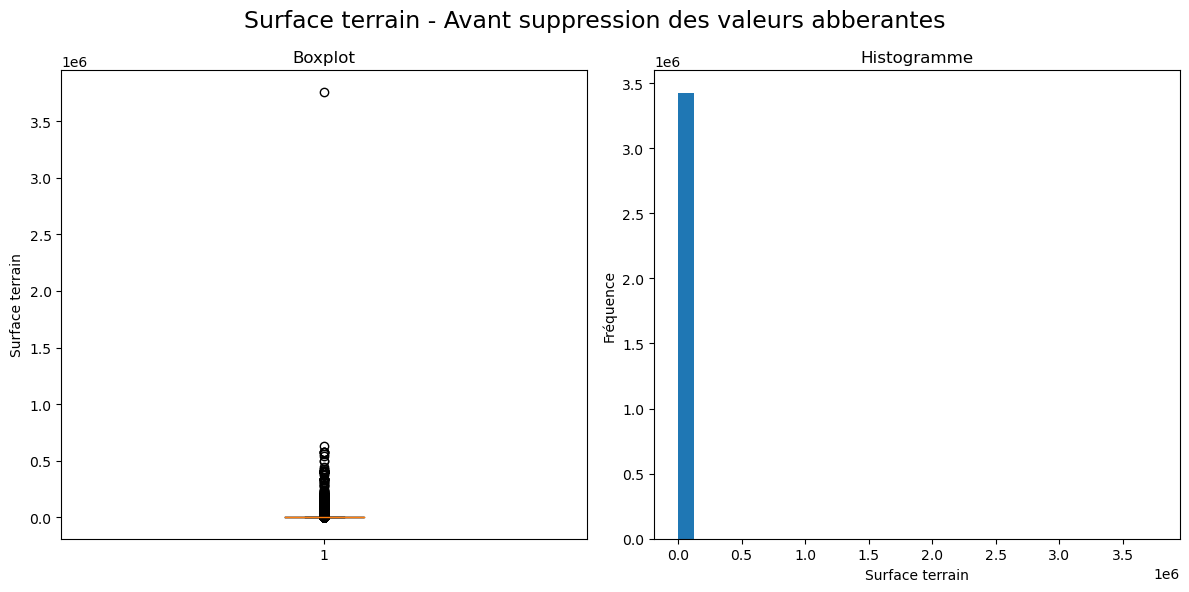

In [49]:
plot_boxplot_histogram(df_filtered, 'Surface terrain', 'Avant suppression des valeurs abberantes')

In [50]:
df_filtered = remove_outliers_iqr(df_filtered, 'Surface terrain')

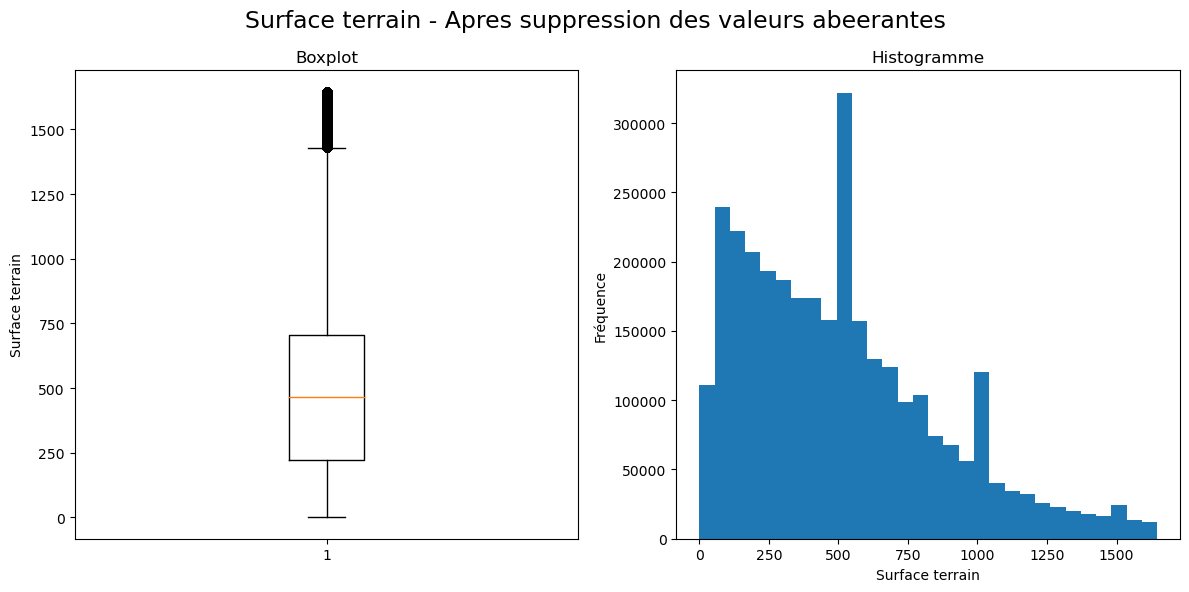

In [51]:
plot_boxplot_histogram(df_filtered, 'Surface terrain', 'Apres suppression des valeurs abberantes')

In [52]:
min_value = df_filtered['Surface terrain'].min()
max_value = df_filtered['Surface terrain'].max()
print("Plage de valeurs : ", min_value, "-", max_value)

Plage de valeurs :  0.0 - 1646.0


### Nombre pieces principales

In [53]:
print("Type de données : ", df_filtered['Nombre pieces principales'].dtype)

Type de données :  int32


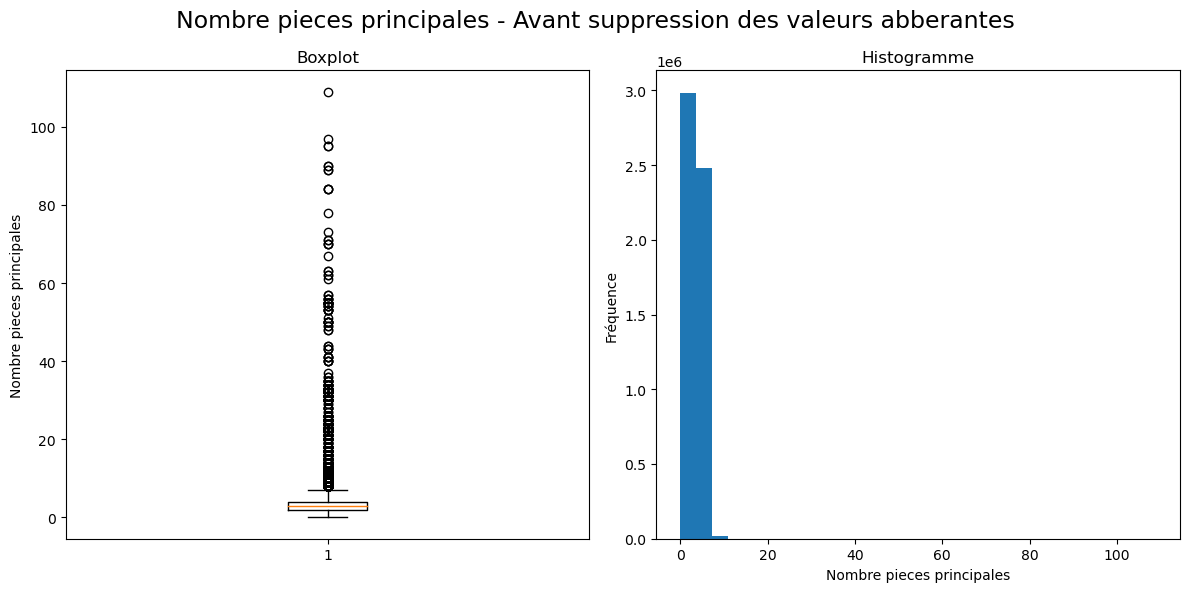

In [54]:
plot_boxplot_histogram(df_filtered, 'Nombre pieces principales', 'Avant suppression des valeurs abberantes')

In [55]:
df_filtered = remove_outliers_iqr(df_filtered, 'Nombre pieces principales')

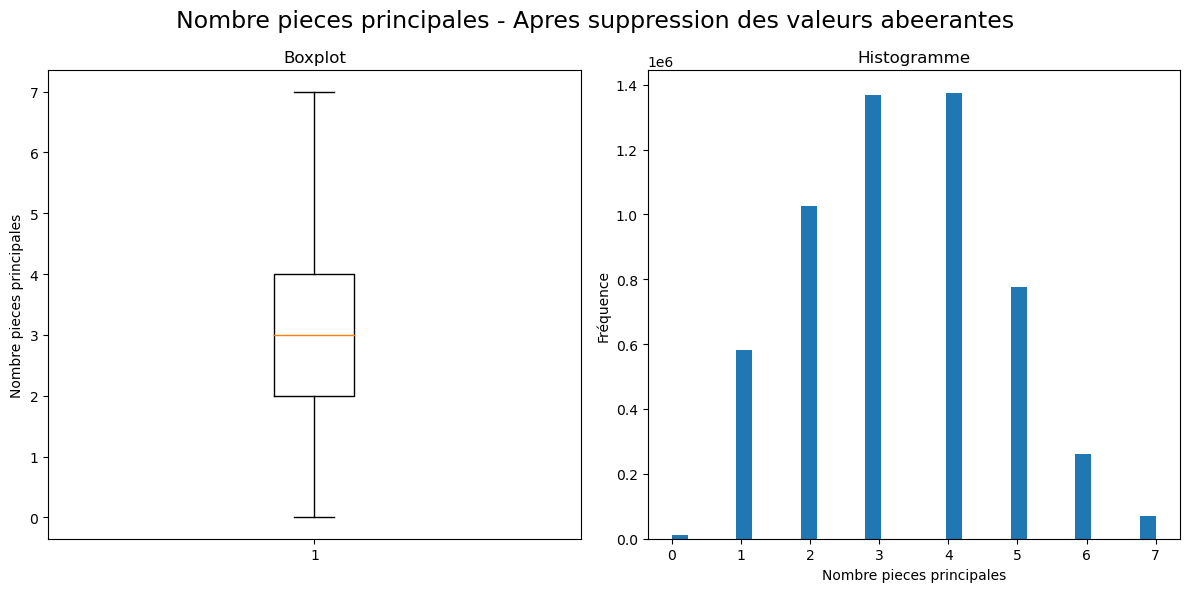

In [56]:
plot_boxplot_histogram(df_filtered, 'Nombre pieces principales', 'Apres suppression des valeurs abberantes')

In [57]:
min_value = df_filtered['Nombre pieces principales'].min()
max_value = df_filtered['Nombre pieces principales'].max()
print("Plage de valeurs : ", min_value, "-", max_value)

Plage de valeurs :  0 - 7


### Nombre de lots

In [58]:
print("Type de données : ", df_filtered['Nombre de lots'].dtype)

Type de données :  int64


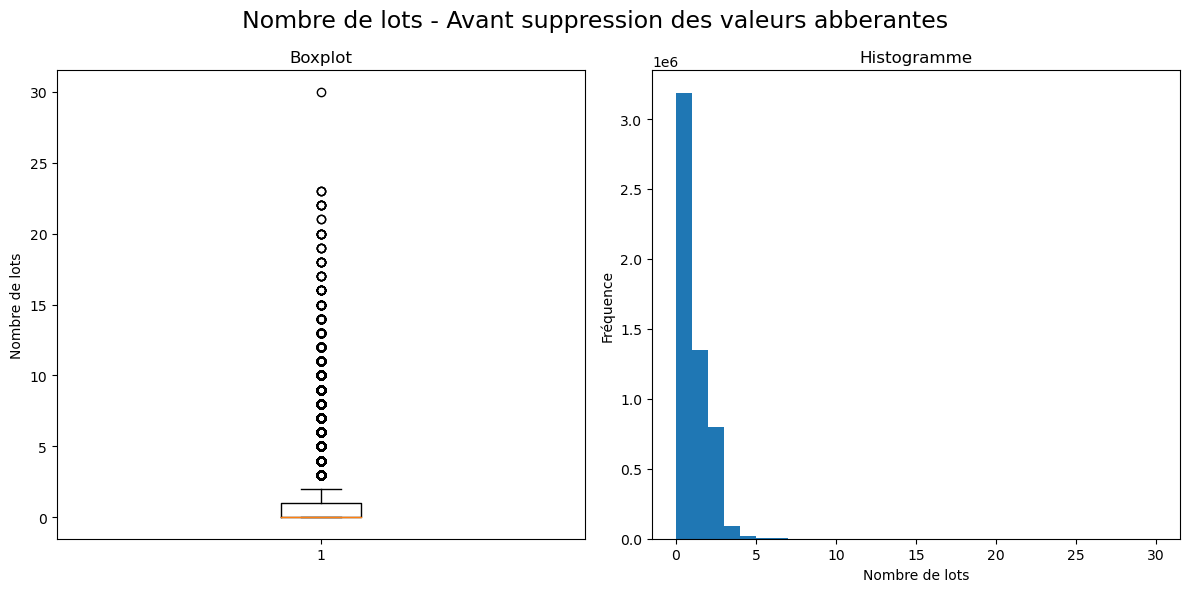

In [59]:
plot_boxplot_histogram(df_filtered, 'Nombre de lots', 'Avant suppression des valeurs abberantes')

In [60]:
df_filtered = remove_outliers_iqr(df_filtered, 'Nombre de lots')

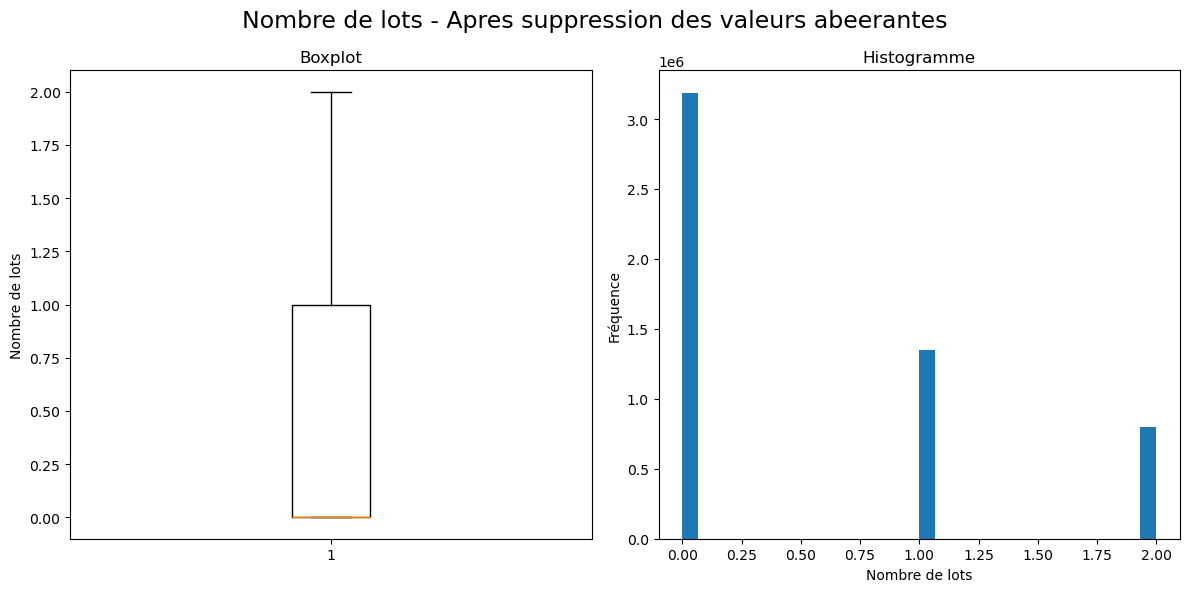

In [61]:
plot_boxplot_histogram(df_filtered, 'Nombre de lots', 'Apres suppression des valeurs abberantes')

In [62]:
min_value = df_filtered['Nombre de lots'].min()
max_value = df_filtered['Nombre de lots'].max()
print("Plage de valeurs : ", min_value, "-", max_value)

Plage de valeurs :  0 - 2


### 2.2.2) Variables qualitatives

In [63]:
def plot_pie_chart(df, column, n):
    counts = df[column].value_counts().nlargest(n)
    plt.figure(figsize=(7, 7))
    plt.title(column)
    counts.plot.pie(autopct='%1.1f%%', labels=counts.index)
    plt.ylabel('')
    plt.show()

### Nature mutation

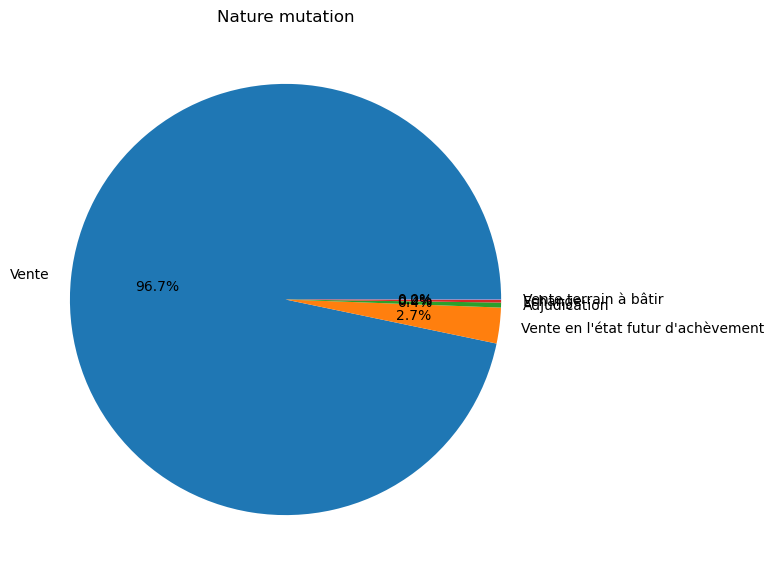

In [64]:
plot_pie_chart(df_filtered, 'Nature mutation', 5)

La vente est la nature de mutation la plus courante. Elle represente 96.9% des demandes de valeurs financieres.
La variable `Nature de muataion` ne sera donc pas utiliser pour la modelisation due a son homogénéité.

### Type de voie

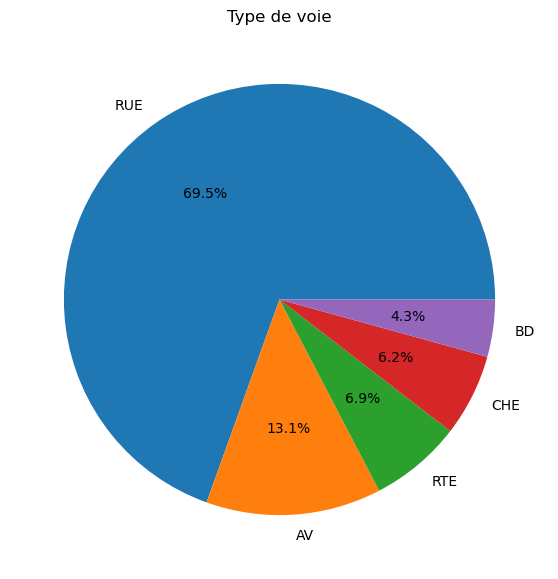

In [65]:
plot_pie_chart(df_filtered, 'Type de voie', 5)

Le type de voie est retenu pour la modélisation

### Type local

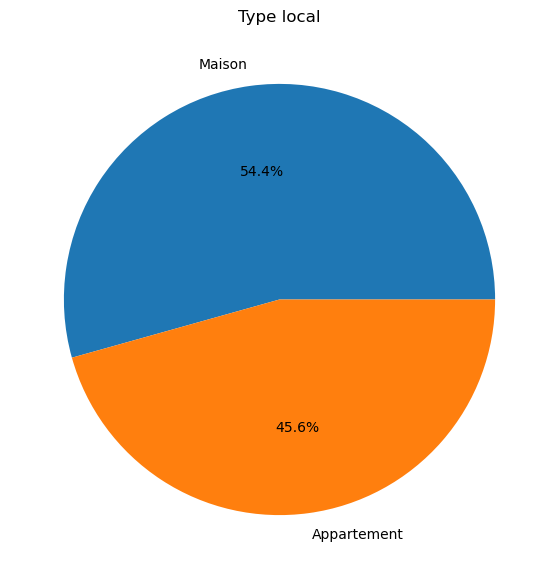

In [66]:
plot_pie_chart(df_filtered, 'Type local', 5)

La modélisation ne porte que sur le prix des appartements. Cette variable n'est pas retenu pour la modélisation

### Nature culture

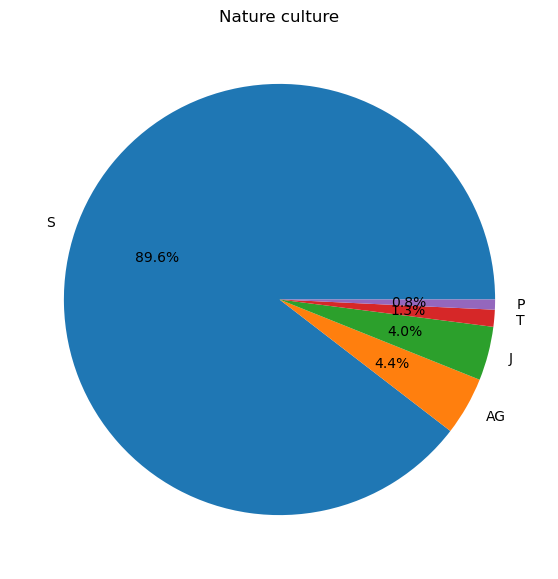

In [67]:
plot_pie_chart(df_filtered, 'Nature culture', 5)

Cette variable est retenu pour la modélisation

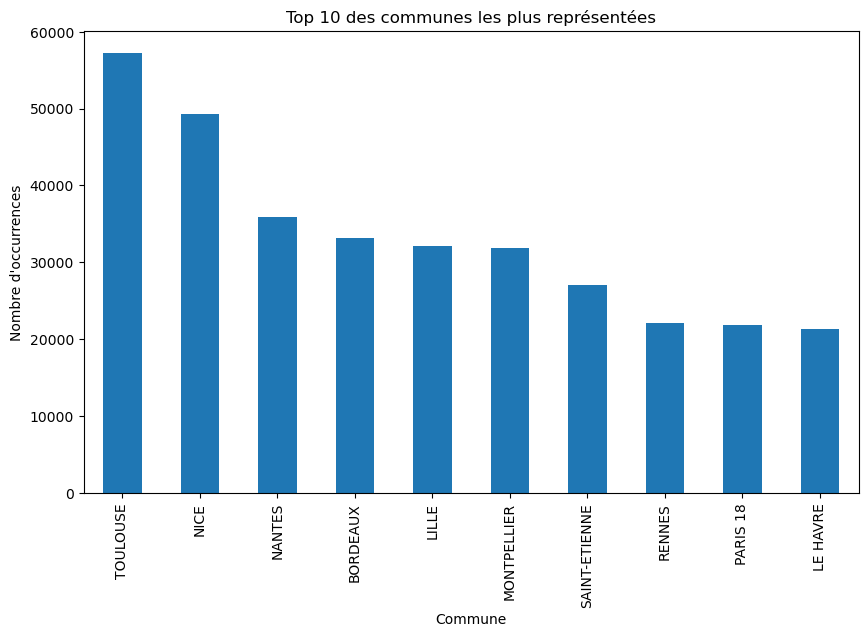

In [68]:
commune_counts = df['Commune'].value_counts()
plt.figure(figsize=(10, 6))
commune_counts.head(10).plot(kind='bar')
plt.title('Top 10 des communes les plus représentées')
plt.xlabel('Commune')
plt.ylabel('Nombre d\'occurrences')
plt.show()

## 2.3) Relations entre variable caractéristiques et la variable cible

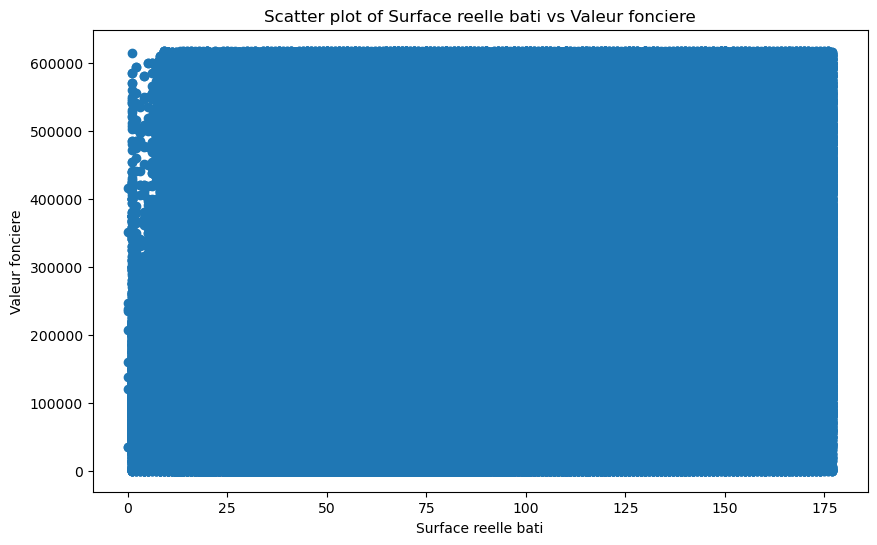

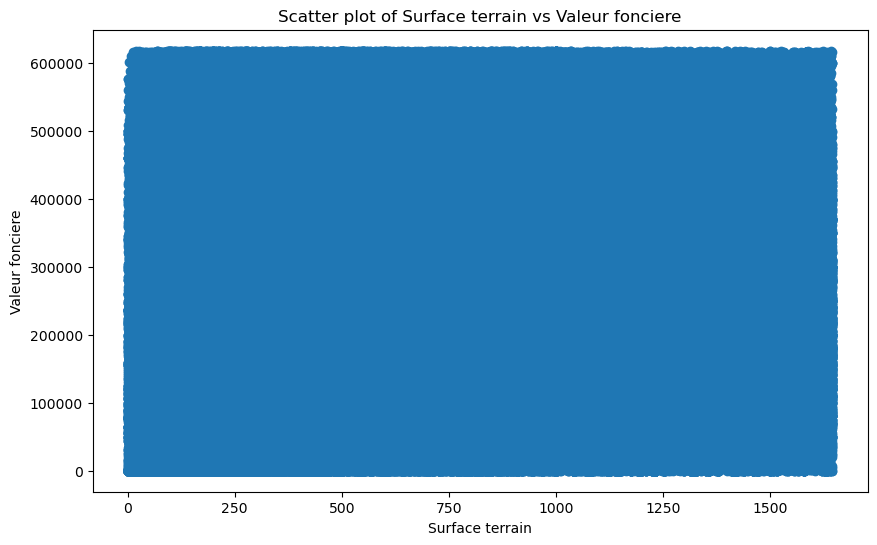

In [69]:
columns = df_[df_.index.year == 2022].select_dtypes(include=[np.number]).drop(['Nombre de lots', 'Prix au metre carre', 'Nombre pieces principales'], axis=1).columns.tolist()
columns.remove('Valeur fonciere') 

for col in columns:
    plt.figure(figsize=(10, 6))
    plt.scatter(df_filtered[col], df_filtered['Valeur fonciere'])
    plt.xlabel(col)
    plt.ylabel('Valeur fonciere')
    plt.title(f'Scatter plot of {col} vs Valeur fonciere')
    plt.show()


## 2.4) Corrélations entre les variables

<Axes: >

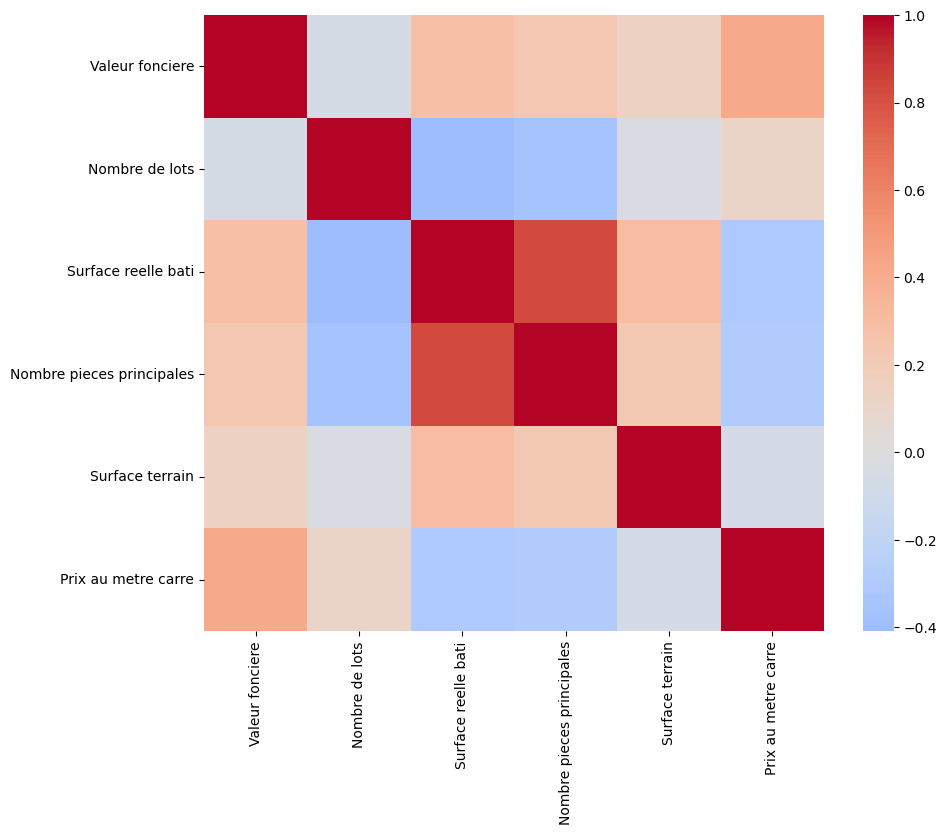

In [70]:
corr_matrix = df_filtered.select_dtypes(include=[np.number]).corr()

plt.figure(figsize=(10, 8))

sns.heatmap(corr_matrix, cmap='coolwarm', center=0)

In [71]:
# Obtenir les paires de corrélation différentes de 1 et sans doublons
corr_pairs = corr_matrix.unstack()
corr_pairs = corr_pairs[corr_pairs != 1]
corr_pairs = corr_pairs[~corr_pairs.index.duplicated(keep='first')]

# Trier par valeur absolue en conservant le signe
sorted_pairs = corr_pairs.reindex(corr_pairs.abs().sort_values(ascending=False).index)
sorted_pairs = sorted_pairs.drop_duplicates()
print(sorted_pairs)


Surface reelle bati        Nombre pieces principales    0.828881
Valeur fonciere            Prix au metre carre          0.421763
Nombre de lots             Surface reelle bati         -0.408366
Nombre pieces principales  Nombre de lots              -0.360486
Prix au metre carre        Surface reelle bati         -0.317471
Surface terrain            Surface reelle bati          0.302915
Nombre pieces principales  Prix au metre carre         -0.289185
Surface reelle bati        Valeur fonciere              0.281407
Nombre pieces principales  Valeur fonciere              0.234445
                           Surface terrain              0.221473
Valeur fonciere            Surface terrain              0.137828
Nombre de lots             Prix au metre carre          0.117526
Prix au metre carre        Surface terrain             -0.062252
Nombre de lots             Valeur fonciere             -0.052053
Surface terrain            Nombre de lots              -0.031330
dtype: float64


## 2.5) Interprétations et visualisations pertinentes autour d'une année

Analyse sur 2022

In [72]:
df_2022 = df_filtered[ df_filtered.index.year==2022].sort_index()

Text(0, 0.5, 'Valeur fonciere')

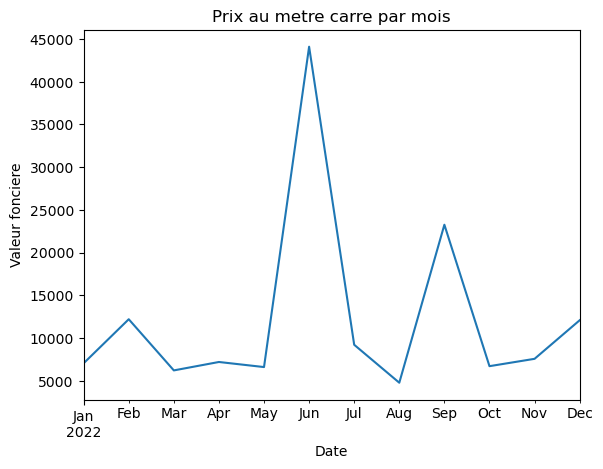

In [73]:
monthly_mean = df[df.index.year==2022]['Prix au metre carre'].resample('M').mean()

plt.figure()
monthly_mean.plot()
plt.title('Prix au metre carre par mois')
plt.xlabel('Date')
plt.ylabel('Valeur fonciere')

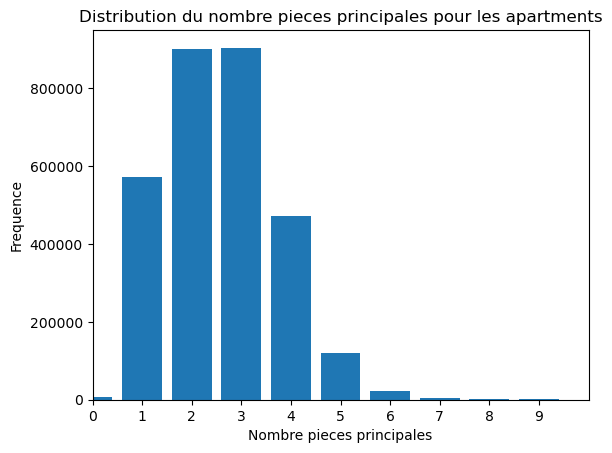

In [74]:
counts = df[df['Type local'] == 'Appartement']['Nombre pieces principales'].value_counts().sort_index()
labels = counts.index
plt.bar(labels, counts)
plt.xlabel('Nombre pieces principales')
plt.ylabel('Frequence')
plt.title('Distribution du nombre pieces principales pour les apartments')
plt.xticks(range(10))
plt.xlim(0, 10)
plt.show()

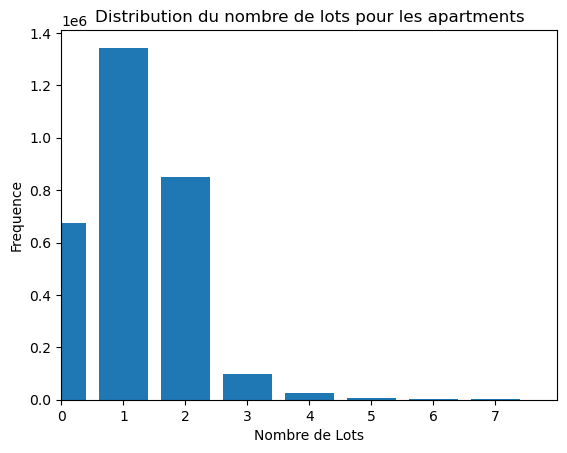

In [75]:
counts = df[df['Type local'] == 'Appartement']['Nombre de lots'].value_counts().sort_index()
labels = counts.index
plt.bar(labels, counts)
plt.xlabel('Nombre de Lots')
plt.ylabel('Frequence')
plt.title('Distribution du nombre de lots pour les apartments')
plt.xticks(range(8))
plt.xlim(0, 8)
plt.show()

In [76]:
df_filtered = remove_outliers_iqr(df_filtered, 'Prix au metre carre')

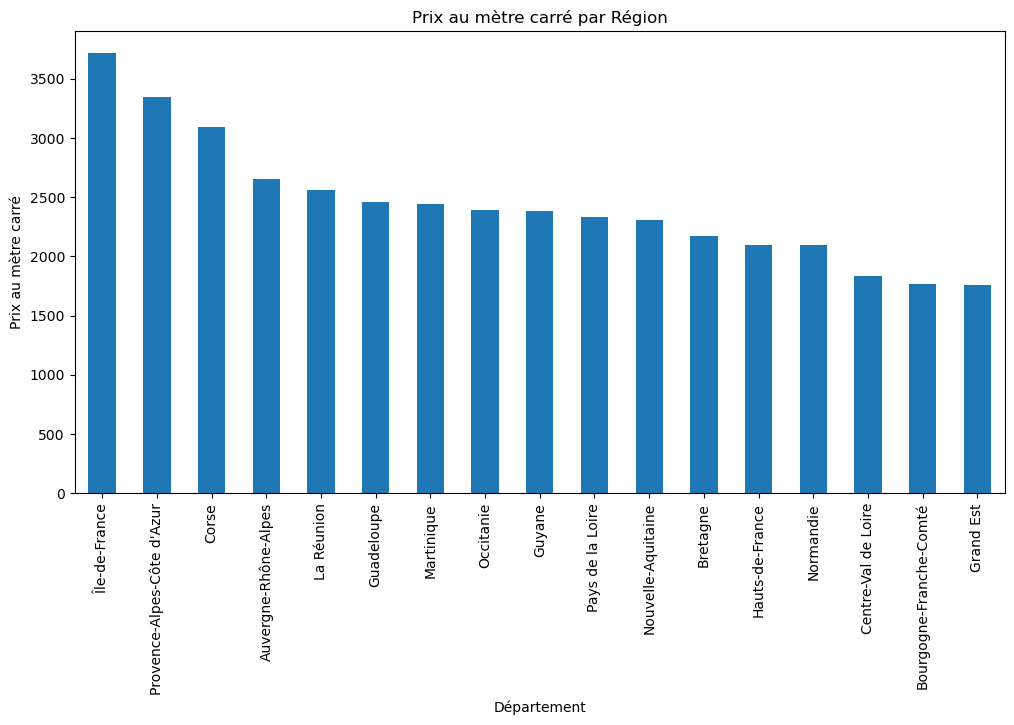

In [77]:
mean_price_by_dept = df_filtered.groupby('Region')['Prix au metre carre'].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
mean_price_by_dept.plot(kind='bar')
plt.title('Prix au mètre carré par Région')
plt.xlabel('Département')
plt.ylabel('Prix au mètre carré')
plt.show()

In [78]:
def create_choropleth_map(df, column, color='YlOrRd'):
    # Read the geojson file
    geo_data = gpd.read_file('departements.json')

    # Calculate the mean value per department
    mean_value = df.groupby('Code departement')[column].mean().reset_index()

    # Merge the geo data with the mean value
    geo_data = geo_data.merge(mean_value, left_on='code', right_on='Code departement')

    # Create a folium map
    m = folium.Map(location=[46.603354, 1.888334], zoom_start=5.5) # centered around France

    # Add the choropleth layer to the map
    folium.Choropleth(
        geo_data=geo_data.to_json(),
        name='choropleth',
        data=geo_data,
        columns=['Code departement', column],
        key_on='feature.properties.code',
        fill_color=color,
        fill_opacity=0.5,
        line_opacity=0.2,
        legend_name=f'{column} (mean)',
        highlight=True
    ).add_to(m)

    # Add a control layer to the map
    folium.LayerControl().add_to(m)

    # Display the map
    return m

In [79]:
create_choropleth_map(df_2022, 'Valeur fonciere')

## Comparaison de avant et apres COVID

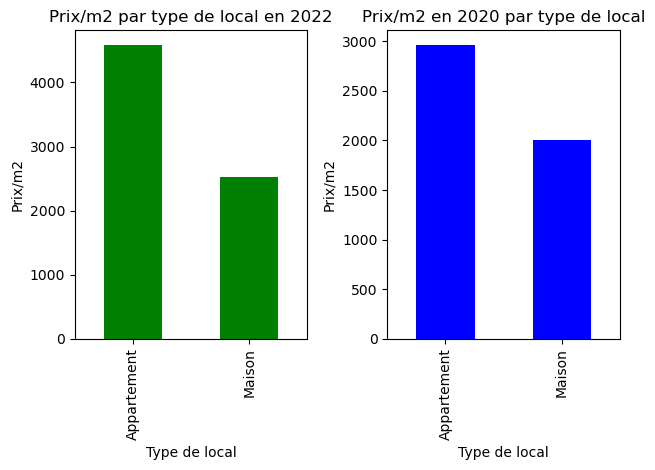

In [80]:
df_2020 = df_filtered[ df_filtered.index.year==2018].sort_index()
df_2022pm = df_2022.groupby(['Type local'])['Prix au metre carre'].mean()
df_2020pm = df_2020.groupby(['Type local'])['Prix au metre carre'].mean()

# Création de la figure avec deux sous-graphiques
figure, axes = plt.subplots(1, 2)

# Graphique de gauche (df_Type_local)
df_2022pm.plot(kind='bar', color='green', ax=axes[0])
axes[0].set_title('Prix/m2 par type de local en 2022')
axes[0].set_xlabel('Type de local')
axes[0].set_ylabel('Prix/m2')

# Graphique de droite (df_2018_Type_local)
df_2020pm.plot(kind='bar', color='blue', ax=axes[1])
axes[1].set_title('Prix/m2 en 2020 par type de local')
axes[1].set_xlabel('Type de local')
axes[1].set_ylabel('Prix/m2')

# Ajustement de l'espacement entre les sous-graphiques
plt.tight_layout()

# Affichage du graphique
plt.show()

In [81]:
df_2022 = df_filtered[ df_filtered.index.year==2022]
df_2018 = df_filtered[ df_filtered.index.year==2020]

map1 = create_choropleth_map(df_2022, 'Valeur fonciere')
map2 = create_choropleth_map(df_2018, 'Valeur fonciere')

map1.save('map1.html')
map2.save('map2.html')

# Display the maps side by side using HTML iframes
html_code = f"""
    <table style="width:100%">
        <tr>
            <td> <iframe src='map1.html' width='100%' height='500'></iframe> </td>
            <td> <iframe src='map2.html' width='100%' height='500'></iframe> </td>
        </tr>
    </table>
    """

display(HTML(html_code))

In [82]:
df_2022 = df_filtered[ df_filtered.index.year==2022].reset_index()
df_2018 = df_filtered[ df_filtered.index.year==2020].reset_index()

In [83]:
df_2022['diff Valeur fonciere'] = df_2022['Valeur fonciere'] - df_2018['Valeur fonciere']

In [84]:
create_choropleth_map(df_2022, 'diff Valeur fonciere')

On observe bien que la region Île-de-France est la region ave la plus forte valeur fonciere en moyenne.
On observe que les litteraux ont en moyenne une valeur fonciere plus élevé que le centre de la france.

# 4) Modelisation

## 4.1) Première partie : Apprentissage non supervisé

### Ici on va utiliser df_model afin de produire un dendogramme pour nous permettre d'analyser les cluster.

### Grace à fastcluster on va pouvoir crée la matrice de linkage de facon optimiser

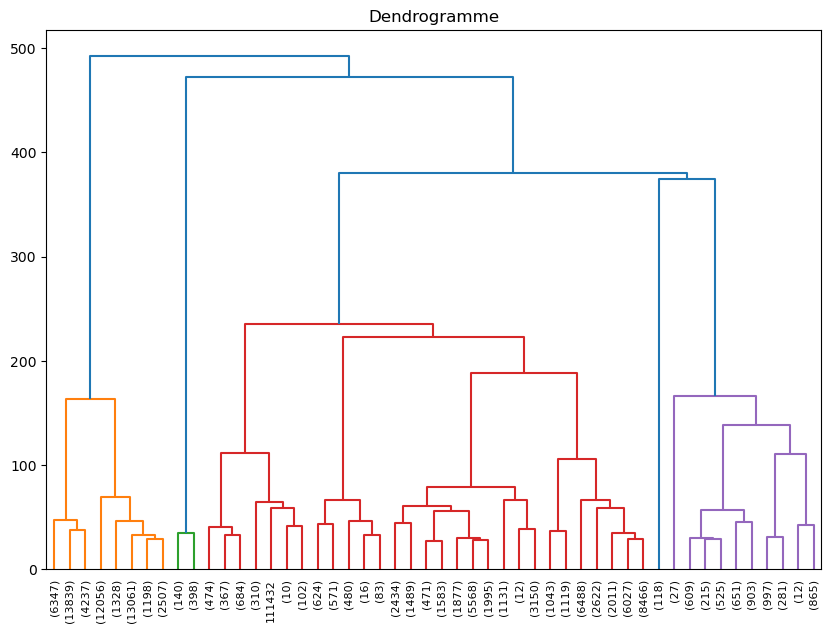

In [86]:
# Création d'une copie du dataframe sous le nom df_non_superviser
df_non_superviserALL = df_model.copy()

# Vérifiez si les colonnes existent avant de les supprimer
for column in ['Type de voie', 'Nature mutation']:
    if column in df_non_superviserALL.columns:
        df_non_superviserALL = df_non_superviserALL.drop([column], axis=1)
        
# Normalisation des données
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_non_superviserALL)

# Création de la matrice de linkage
Z = fastcluster.linkage_vector(df_scaled, method='ward')

# Visualisation du dendrogramme
plt.figure(figsize=(10, 7))
plt.title("Dendrogramme")
dendrogram(Z, truncate_mode='lastp', p=50)  # Affiche seulement les 50 dernières branches fusionnées
plt.show()

# Détermination des clusters à partir de la matrice de linkage
labels = fcluster(Z, t=5, criterion='maxclust')

# Ajouter les clusters au dataframe
df_non_superviserALL['Cluster'] = labels    

### Ici on a un dendogramme qui nous montre 5 cluster distinct

In [87]:
print(df_non_superviserALL['Cluster'].unique())
print(df_non_superviserALL['Cluster'].value_counts())

[1 3 2 5 4]
Cluster
1    54573
3    51208
5     5085
2      538
4      118
Name: count, dtype: int64


### Ici on definit les fonctions qui vont nous servir à afficher les graphs boite à moustache et à filtrer les valeurs aberantes

In [88]:
def filter_aberation(df, column):
    """Filtre les valeurs aberrantes d'une colonne spécifique dans un DataFrame"""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    df_filtered = df[~((df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR)))]
    return df_filtered


def analyse_cluster(df, column):
    """Analyse une colonne spécifique dans un DataFrame groupé par clusters"""
    # Calcule la moyenne pour chaque cluster
    mean_values = df.groupby('Cluster')[column].mean()
    print(f"Moyenne de '{column}' pour chaque cluster:")
    print(mean_values)

    # Calcule la médiane pour chaque cluster
    median_values = df.groupby('Cluster')[column].median()
    print(f"\nMédiane de '{column}' pour chaque cluster:")
    print(median_values)

    # Calcule l'écart-type pour chaque cluster
    std_values = df.groupby('Cluster')[column].std()
    print(f"\nÉcart-type de '{column}' pour chaque cluster:")
    print(std_values)

    # Crée un boxplot de la distribution par cluster
    plt.figure(figsize=(10, 6))
    sns.boxplot(x="Cluster", y=column, data=df)
    plt.title(f"Distribution de '{column}' pour chaque cluster")
    plt.show()

Moyenne de 'Valeur fonciere' pour chaque cluster:
Cluster
1    6.497493e+06
2    9.758836e+06
3    2.051803e+07
4    1.249132e+09
5    3.038423e+07
Name: Valeur fonciere, dtype: float64

Médiane de 'Valeur fonciere' pour chaque cluster:
Cluster
1    2.290000e+06
2    2.850000e+05
3    6.780000e+06
4    1.249132e+09
5    3.328000e+07
Name: Valeur fonciere, dtype: float64

Écart-type de 'Valeur fonciere' pour chaque cluster:
Cluster
1    9.924524e+06
2    1.578368e+07
3    4.094274e+07
4    0.000000e+00
5    2.167728e+07
Name: Valeur fonciere, dtype: float64


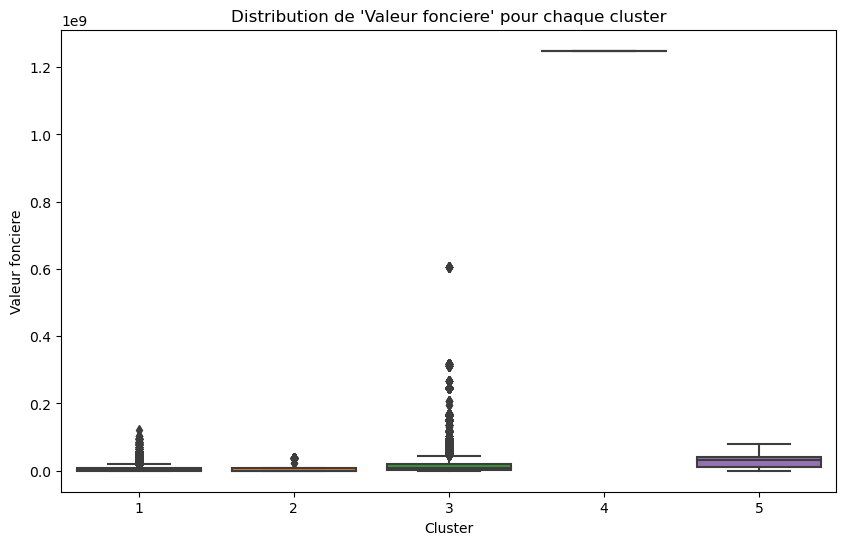

In [89]:
analyse_cluster(df_non_superviserALL, 'Valeur fonciere')

### On a ici la distribution des valeur fonciere en fonction des clusters. Néanmoins le graphique n'est pas lisible car il y a des valeurs aberantes

Moyenne de 'Valeur fonciere' pour chaque cluster:
Cluster
1    5.347946e+06
2    1.082306e+06
3    7.256176e+06
5    1.314440e+07
Name: Valeur fonciere, dtype: float64

Médiane de 'Valeur fonciere' pour chaque cluster:
Cluster
1     2120000.0
2      235000.0
3     3936243.2
5    12256606.0
Name: Valeur fonciere, dtype: float64

Écart-type de 'Valeur fonciere' pour chaque cluster:
Cluster
1    7.054228e+06
2    2.569575e+06
3    8.226010e+06
5    1.017578e+07
Name: Valeur fonciere, dtype: float64


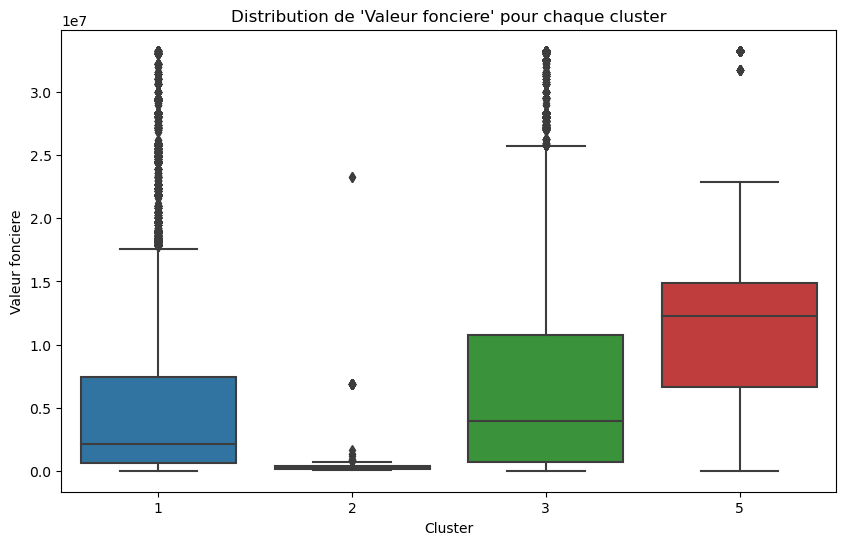

In [90]:
# Filtrer les valeurs aberrantes
df_filtered = filter_aberation(df_non_superviserALL, 'Valeur fonciere')

analyse_cluster(df_filtered, 'Valeur fonciere')

### Ici on a la distribution des valeur fonciere en fonction des clusters après le filtrage des données de manière a retirer les valeurs aberantes. On voit que le cluster 4 disparait car il contenait uniquement des valeurs trés éléver. On peut en déduire que le cluster 4 est un cluster caractériser par des residences trés couteuse (plus de 1 milliard de valeur foncière en mediane). De plus on voit aussi que les clusters 1 et 3 ont des valeurs similaires, cela montre surment qu'ils ont des points en commun. Le cluster 2 a une valeur mediane trés faible et représente surement des logements bon marcher, contrairement au cluster 5 qui représente surment des appartements de luxe car ayant une valeur mediane trés élever.

Moyenne de 'Surface terrain' pour chaque cluster:
Cluster
1     1446.838693
2      289.386617
3     3384.782651
4      790.186441
5    49088.229302
Name: Surface terrain, dtype: float64

Médiane de 'Surface terrain' pour chaque cluster:
Cluster
1      503.0
2      121.5
3     1259.0
4      502.0
5    46170.0
Name: Surface terrain, dtype: float64

Écart-type de 'Surface terrain' pour chaque cluster:
Cluster
1     2266.682971
2      370.916740
3     4447.077622
4      461.892020
5    26478.833575
Name: Surface terrain, dtype: float64


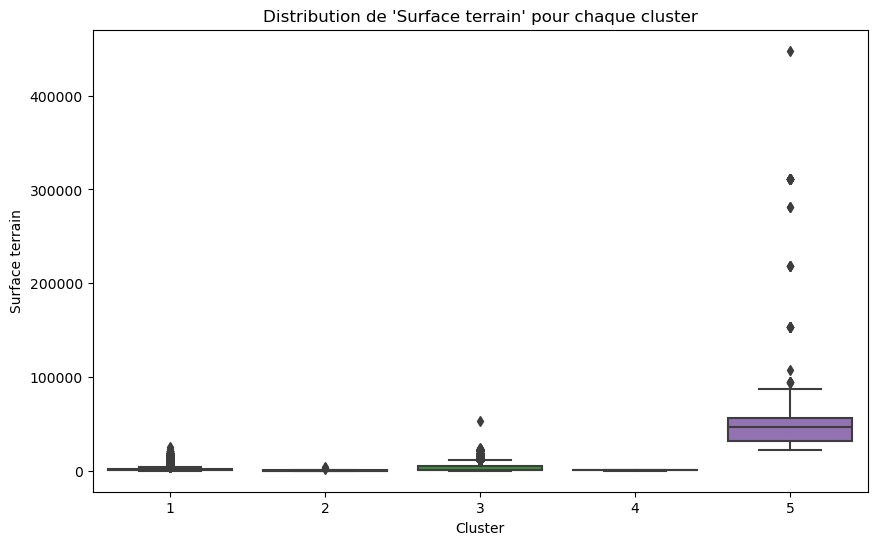

In [91]:
df_non_superviserALL['Surface terrain'] = df_model['Surface terrain']

analyse_cluster(df_non_superviserALL, 'Surface terrain')

### On a ici la distribution des surface terrain en fonction des clusters. Néanmoins le graphique n'est pas lisible car il y a des valeurs aberantes. On peux cependant remarquer que le cluster 5 qui se démarque avec une median de surface nettement supérieur a celle des autre cluster. On suppose donc que ce sont de trés grande résidence avec des jardins ou des lieux naturels, possiblement des chateaux par exemple.

Moyenne de 'Surface terrain' pour chaque cluster:
Cluster
1    1194.790771
2     289.386617
3    1874.607854
4     790.186441
Name: Surface terrain, dtype: float64

Médiane de 'Surface terrain' pour chaque cluster:
Cluster
1    497.0
2    121.5
3    900.0
4    502.0
Name: Surface terrain, dtype: float64

Écart-type de 'Surface terrain' pour chaque cluster:
Cluster
1    1518.048895
2     370.916740
3    2039.994783
4     461.892020
Name: Surface terrain, dtype: float64


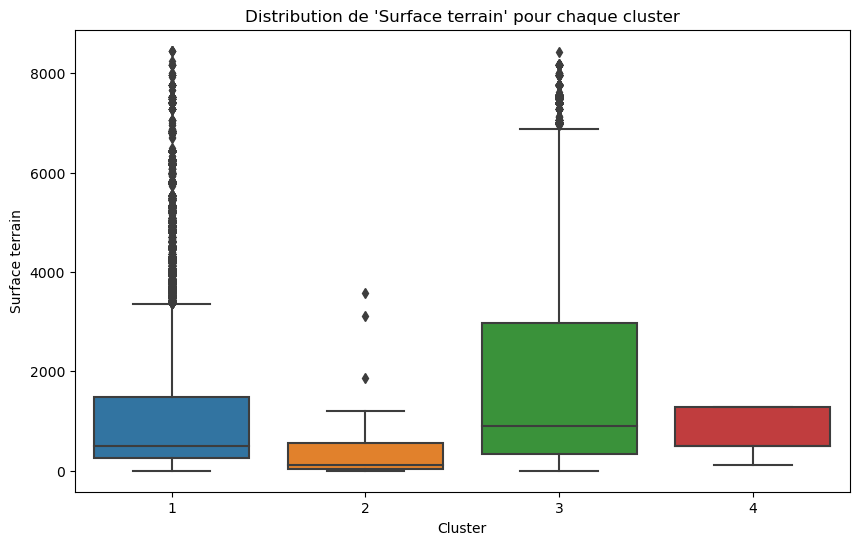

In [114]:
# Filtrer les valeurs aberrantes
df_filtered = filter_aberation(df_non_superviserALL, 'Surface terrain')

analyse_cluster(df_filtered, 'Surface terrain')

### Ici on voit que la surface de terrain du cluster 3 varie enormement en fonction des propriétés mais la mediane est généralement plus haute que les autres clusters, on peux donc en deduire que ce cluster représente les résidence avec un jardin. De plus la median de cluster 2 est trés basse ce qui correspond effectivement à des propriétés modeste.

Moyenne de 'Nombre pieces principales' pour chaque cluster:
Cluster
1    1.544974
2    2.634888
3    3.246984
4    2.188034
5    2.695146
Name: Nombre pieces principales, dtype: float64

Médiane de 'Nombre pieces principales' pour chaque cluster:
Cluster
1    2.0
2    3.0
3    3.0
4    2.0
5    3.0
Name: Nombre pieces principales, dtype: float64

Écart-type de 'Nombre pieces principales' pour chaque cluster:
Cluster
1    0.497978
2    0.913182
3    0.610746
4    0.840070
5    1.219026
Name: Nombre pieces principales, dtype: float64


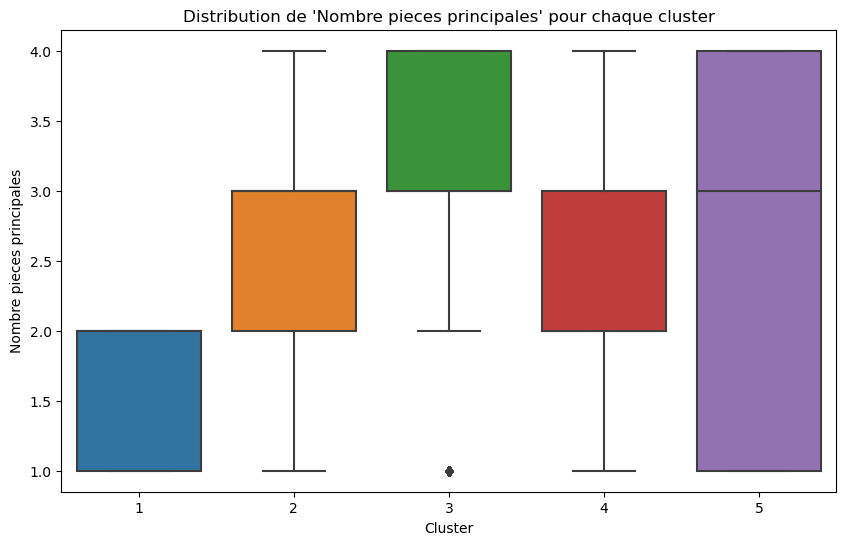

In [93]:
# Filtrer les valeurs aberrantes
df_filtered = filter_aberation(df_non_superviserALL, 'Nombre pieces principales')

analyse_cluster(df_filtered, 'Nombre pieces principales')

### Ici on voit que le cluster 1 ne varie que entre 1 ou 2 piece ce qui peux indiquer qu'il représente les petits appartements de grande ville par exemple. Les clusters 3 et 5 sont ceux qui ont le nombre de piece en mediane les plus élevés, ce qui correspond effectivement a des residences en campagne, avec beaucoup d'espace.

Moyenne de 'Surface reelle bati' pour chaque cluster:
Cluster
1    32.640445
2    60.224138
3    66.791232
4    43.127119
5    57.242532
Name: Surface reelle bati, dtype: float64

Médiane de 'Surface reelle bati' pour chaque cluster:
Cluster
1    32.0
2    57.0
3    65.0
4    33.0
5    64.0
Name: Surface reelle bati, dtype: float64

Écart-type de 'Surface reelle bati' pour chaque cluster:
Cluster
1    12.469012
2    23.729392
3    16.616202
4    20.555760
5    25.816330
Name: Surface reelle bati, dtype: float64


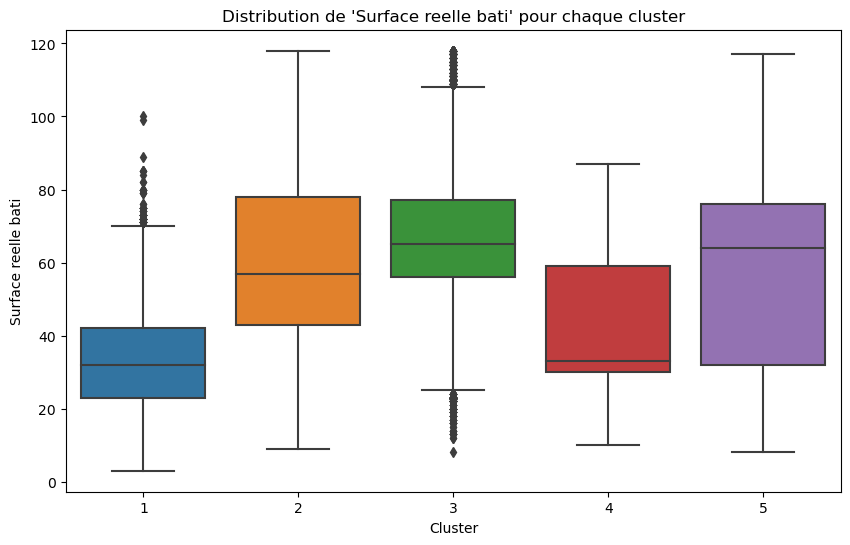

In [94]:
# Filtrer les valeurs aberrantes
df_filtered = filter_aberation(df_non_superviserALL, 'Surface reelle bati')

analyse_cluster(df_filtered, 'Surface reelle bati')

### Ici on voit que les surface reelle bati correponde en equivalent au surface terrain sauf le cluster 5 qui est nettement moi grand qu'avant proportionnellement. Cela suppose que le cluster 5 représente effectivement des propriété avec beaucoup d'espace non bati, sois des jadins ou espace naturelle.

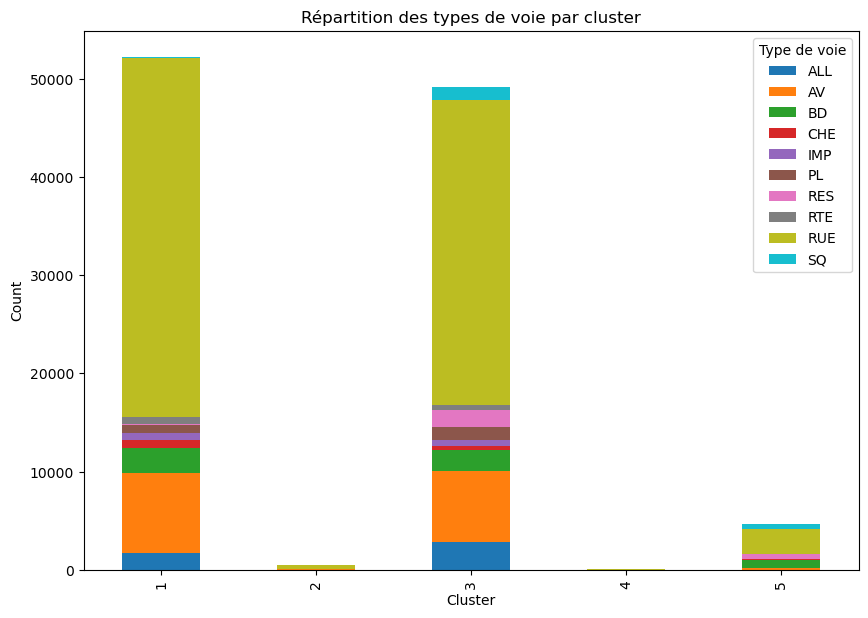

In [98]:
# Compter le nombre de fois où chaque type de voie apparaît
road_type_counts_total = df_non_superviserALL['Type de voie'].value_counts()

# Calculer le pourcentage de chaque type de voie
road_type_percent = road_type_counts_total / len(df_non_superviserALL)

# Retirer les types de voie qui apparaissent dans moins de 1% des observations
df_non_superviserALL_filtered = df_non_superviserALL[df_non_superviserALL['Type de voie'].isin(road_type_percent[road_type_percent > 0.01].index)]

# Calculer le nombre de chaque type de voie par cluster
road_type_counts = df_non_superviserALL_filtered.groupby(['Cluster', 'Type de voie']).size().unstack()

# Remplir les valeurs manquantes par 0
road_type_counts = road_type_counts.fillna(0)

# Tracer le graphique
road_type_counts.plot(kind='bar', stacked=True, figsize=(10, 7))
plt.ylabel('Count')
plt.title('Répartition des types de voie par cluster')
plt.show()

### Ici on voit clairement les proportions de chaque cluster. Les propriété des clusters 1 et 3 sont courantes (petit appartement ou petite maison). Au contraitre les cluster 4, 5 représentant des residences de luxe sont rare. On voit aussi que le cluster 2, qui resprésente des maison bon marché est faible. 

### Pour en revenir au type de voie en fonction des clusters on voie que tout les cluster on tendance a etre composer majoritairement de propriété à coté d'un rue, d'une avenue, d'un boulevard ou d'une allée.

## 4.2) Seconde partie : Apprentissage supervisé

### 4.2.2) Valeurs des variables categorielles pour l' encodage 'OneHot' 

Dans cette partie nous cherchons les valeurs des variables categorielles les plus pertienente a encoder pour la modelisation.
Nous etudirons les variables `Type de voie` et `Nature mutation`.

#### 4.2.2.1) Encode des types de voie

In [98]:
(df_model['Type de voie'].value_counts()/len(df_model))[:5]

Type de voie
RUE    0.632907
AV     0.139694
BD     0.049847
ALL    0.040378
RES    0.020247
Name: count, dtype: float64

Description des 15 types de voies les plus courantes:

1. 'RUE' : Rue - une voie urbaine bordée par des maisons ou des bâtiments.
2. 'AV' : Avenue - une large rue, souvent bordée d'arbres.
3. 'BD' : Boulevard - une large avenue, souvent bordée d'arbres.
4. 'ALL' : Allée - une petite voie, souvent bordée d'arbres.
5. 'PL' : Place - une voie souvent entourée de bâtiments et où plusieurs rues se rencontrent.

In [99]:
# Valeurs de la variable 'Type de voie' retenu
cols_type_voie = ['RUE', 'AV', 'BD', 'ALL', 'PL']

In [100]:
df_model['Type de voie'].isin(cols_type_voie).mean() * 100

88.17004716558168

Ces types de voies representes près de 90% des type de voie.
Les autres types de voies n'apparaitront pas dans la matrice d'encodage 'OneHot'.

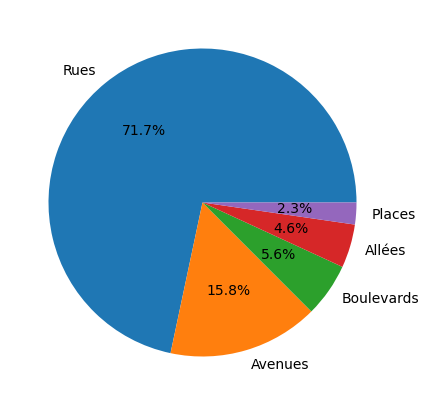

In [101]:
counts = df_model['Type de voie'].value_counts().nlargest(5)
plt.figure(figsize=(5, 5))
counts.plot.pie(autopct='%1.1f%%', labels=['Rues', 'Avenues', 'Boulevards', 'Allées', 'Places'])
plt.ylabel('')
plt.show()

#### 4.2.2.2) Encode de la nature de mutation

In [102]:
df_model['Nature mutation'].value_counts() / len(df_model) * 100

Nature mutation
Vente                                 98.324097
Echange                                0.886821
Adjudication                           0.332670
Vente en l'état futur d'achèvement     0.242105
Vente terrain à bâtir                  0.167680
Expropriation                          0.046628
Name: count, dtype: float64

> Adjudication : Acte juridique par lequel on met des acquéreurs en libre concurrence

In [103]:
# Valeurs de la variable 'Nature mutation' retenu
cols_nature_mutation = ['Vente', 'Echange', 'Adjudication']

### 4.2.3) Pretraitement

Dans cette partie, nous allons préparer les données pour le processus d'apprentissage automatique. Les données se divisent en deux types principaux : numériques et catégorielles. Ces deux types de données nécessitent des traitements différents pour être correctement intégrées dans nos modèles.

Pour les données numériques, nous utilisons un ColumnTransformer qui permet de traiter différemment certaines colonnes. En effet, les colonnes "Nombre de lots" et "Nombre pieces principales" sont laissées intactes, tandis que les colonnes "Surface reelle bati" et "Surface terrain" sont normalisées à l'aide de StandardScaler. Cet outil standardise les valeurs en les recentrant autour de zéro et en les divisant par l'écart-type, ce qui est une pratique courante pour préparer les données numériques pour les algorithmes d'apprentissage automatique.

Pour les données catégoriques, nous avons mis en place une pipeline spécifique. Celle-ci utilise la méthode OneHotEncoder pour transformer les valeurs catégoriques en vecteurs binaires, une représentation plus appropriée pour les modèles de machine learning. Les catégories qui seront encodées pour chaque colonne sont spécifiées dans cols_type_voie et cols_nature_mutation. De plus, pour éviter les erreurs dues à des catégories inconnues, nous avons défini handle_unknown="ignore" pour simplement ignorer ces cas lors de la transformation.

Finalement, nous combinons ces deux pipelines en une seule, grâce à l'utilisation d'un autre ColumnTransformer. Ce dernier est notre préprocesseur principal qui sera appliqué à notre ensemble de données, en veillant à ce que chaque colonne soit traitée de la manière appropriée en fonction de son type. Ce prétraitement est une étape essentielle pour garantir que notre modèle d'apprentissage automatique puisse interpréter correctement les données.

In [104]:
# Colonnes à traiter
num_cols = [
    "Nombre de lots",
    "Surface reelle bati",
    "Nombre pieces principales",
    "Surface terrain",
]
cat_cols = ["Type de voie", "Nature mutation"]

# Catégories pour l'encodage OneHot
cols_type_voie = ['RUE', 'AV', 'RTE', 'ALL', 'CHE', 'BD', 'PL', 'RES', 'CITE', 'IMP', 'VC']
cols_nature_mutation = ["Vente", "Echange", "Adjudication"]

# Pipeline pour les données numériques
num_transformer = ColumnTransformer(
    transformers=[
        ("passthrough", "passthrough", ["Nombre de lots", "Nombre pieces principales"]),
        ("scaler", StandardScaler(), ["Surface reelle bati", "Surface terrain"]),
    ],
    remainder="drop",
)

# Pipeline pour les données catégoriques
cat_pipeline = Pipeline([
        ("onehot",OneHotEncoder(categories=[cols_type_voie, cols_nature_mutation], handle_unknown="ignore"))
])

# Combinaison des deux pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_cols), 
        ("cat", cat_pipeline, cat_cols)
    ]
)

### 4.2.4) Modelisation

In [105]:
def plot_predictions(y_true, y_pred, regressor):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred)
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Analyse des predictions - {regressor.__class__.__name__}')
    plt.axline((0,0), slope=1, color='k', linestyle='--', label='y=x', linewidth=0.8)
    max_xy = max(plt.xlim()[1], plt.ylim()[1])
    plt.xlim(0, max_xy)  
    plt.ylim(0, max_xy)  
    plt.gca().set_aspect('equal')
    plt.show()

In [106]:
def print_score(R2, RMSE, regressor):
    display(Markdown(f'**R^2 score: {R2:.3f} for {regressor.__class__.__name__}**'))
    display(Markdown(f'**RMSE score: {RMSE:.3f} for {regressor.__class__.__name__}**'))

In [107]:
def remove_outliers_iqr(df, column):
    # Calculating the IQR
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Removing outliers
    df_filtered = df[~((df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR)))]

    return df_filtered

In [108]:


def run_regressors(df, regressors, preprocessor):
    scores = []
    predictions = []

    X = df.drop('Valeur fonciere', axis=1)
    y = df['Valeur fonciere']

    # Séparation des données en ensemble d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    for regressor in regressors:
        display(Markdown(f'# {regressor.__class__.__name__}'))

        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', regressor)
        ])

        # Entraînement du modèle sur l'ensemble d'entraînement
        display(pipeline.fit(X_train, y_train))

        # Prédictions sur l'ensemble de test
        y_pred = pipeline.predict(X_test)
        predictions.append(y_pred)

        # Affichage de l'importance des variables pour les modèles d'arbres
        if isinstance(regressor, (RandomForestRegressor, GradientBoostingRegressor, DecisionTreeRegressor)):

            feature_importances = regressor.feature_importances_

            # Get feature names from the preprocessor steps
            num_cols_transformed = pipeline.named_steps['preprocessor'].transformers_[0][2]
            cat_cols_transformed = pipeline.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(cat_cols)

            feature_names = num_cols_transformed + cat_cols_transformed.tolist()
            
            
            
            plt.figure(figsize=(8, 6))
            plt.barh(feature_names, feature_importances)
            plt.xlabel('Importance')
            plt.ylabel('Variable')
            plt.title(f'Importance des caractéristiques - {regressor}')
            plt.show()

            plot_predictions(y_test, y_pred, regressor)

        R2 = pipeline.score(X_test, y_test)
        RMSE = np.sqrt(mean_squared_error(y_test, y_pred))

        scores.append({'Regressor': regressor.__class__.__name__,
                       'R2': R2,
                       'RMSE': RMSE})

    scores_df = pd.DataFrame(scores)
    display(scores_df)


In [109]:

regressors = [
    LinearRegression(),
    GradientBoostingRegressor(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
]

# LinearRegression

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  ColumnTransformer(transformers=[('passthrough',
                                                                                   'passthrough',
                                                                                   ['Nombre '
                                                                                    'de '
                                                                                    'lots',
                                                                                    'Nombre '
                                                                                    'pieces '
                                                                                    'principales']),
                                                                                  ('scaler',
                                                                                   StandardScaler(),
                                                                                   ['Surface '
                                                                                    'reelle '
                                                                                    'bati',
                                                                                    'Surface '
                                                                                    'terrain'])]),
                                                  ['Nombre de lots',
                                                   'Surface reelle bati',
                                                   'Nombre pieces principales',
                                                   'Surface terrain']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(categories=[['RUE',
                                                                                              'AV',
                                                                                              'RTE',
                                                                                              'ALL',
                                                                                              'CHE',
                                                                                              'BD',
                                                                                              'PL',
                                                                                              'RES',
                                                                                              'CITE',
                                                                                              'IMP',
                                                                                              'VC'],
                                                                                             ['Vente',
                                                                                              'Echange',
                                                                                              'Adjudication']],
                                                                                 handle_unknown='ignore'))]),
                                                  ['Type de voie',
                                                   'Nature mutation'])])),
                ('regressor', LinearRegression())])

# GradientBoostingRegressor

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  ColumnTransformer(transformers=[('passthrough',
                                                                                   'passthrough',
                                                                                   ['Nombre '
                                                                                    'de '
                                                                                    'lots',
                                                                                    'Nombre '
                                                                                    'pieces '
                                                                                    'principales']),
                                                                                  ('scaler',
                                                                                   StandardScaler(),
                                                                                   ['Surface '
                                                                                    'reelle '
                                                                                    'bati',
                                                                                    'Surface '
                                                                                    'terrain'])]),
                                                  ['Nombre de lots',
                                                   'Surface reelle bati',
                                                   'Nombre pieces principales',
                                                   'Surface terrain']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(categories=[['RUE',
                                                                                              'AV',
                                                                                              'RTE',
                                                                                              'ALL',
                                                                                              'CHE',
                                                                                              'BD',
                                                                                              'PL',
                                                                                              'RES',
                                                                                              'CITE',
                                                                                              'IMP',
                                                                                              'VC'],
                                                                                             ['Vente',
                                                                                              'Echange',
                                                                                              'Adjudication']],
                                                                                 handle_unknown='ignore'))]),
                                                  ['Type de voie',
                                                   'Nature mutation'])])),
                ('regressor', GradientBoostingRegressor())])

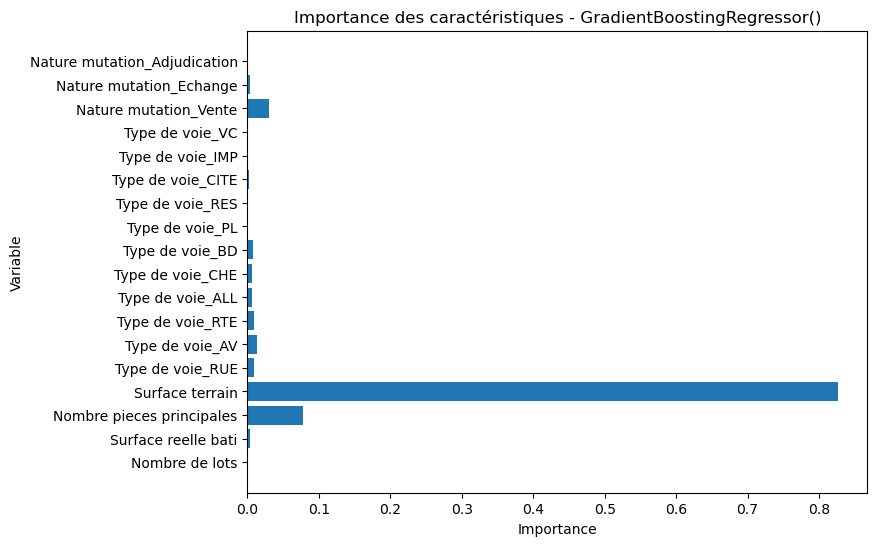

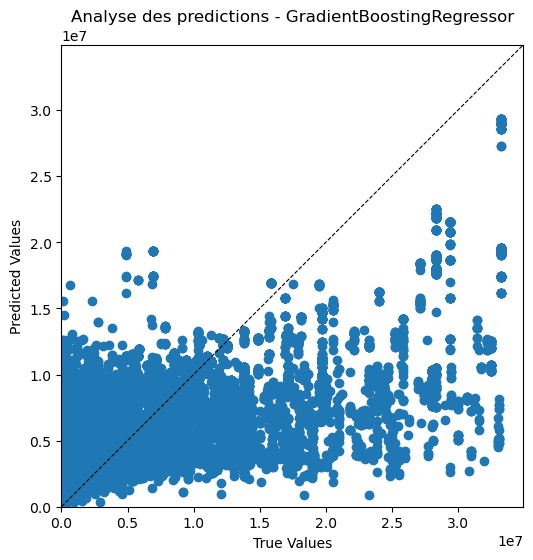

# DecisionTreeRegressor

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  ColumnTransformer(transformers=[('passthrough',
                                                                                   'passthrough',
                                                                                   ['Nombre '
                                                                                    'de '
                                                                                    'lots',
                                                                                    'Nombre '
                                                                                    'pieces '
                                                                                    'principales']),
                                                                                  ('scaler',
                                                                                   StandardScaler(),
                                                                                   ['Surface '
                                                                                    'reelle '
                                                                                    'bati',
                                                                                    'Surface '
                                                                                    'terrain'])]),
                                                  ['Nombre de lots',
                                                   'Surface reelle bati',
                                                   'Nombre pieces principales',
                                                   'Surface terrain']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(categories=[['RUE',
                                                                                              'AV',
                                                                                              'RTE',
                                                                                              'ALL',
                                                                                              'CHE',
                                                                                              'BD',
                                                                                              'PL',
                                                                                              'RES',
                                                                                              'CITE',
                                                                                              'IMP',
                                                                                              'VC'],
                                                                                             ['Vente',
                                                                                              'Echange',
                                                                                              'Adjudication']],
                                                                                 handle_unknown='ignore'))]),
                                                  ['Type de voie',
                                                   'Nature mutation'])])),
                ('regressor', DecisionTreeRegressor())])

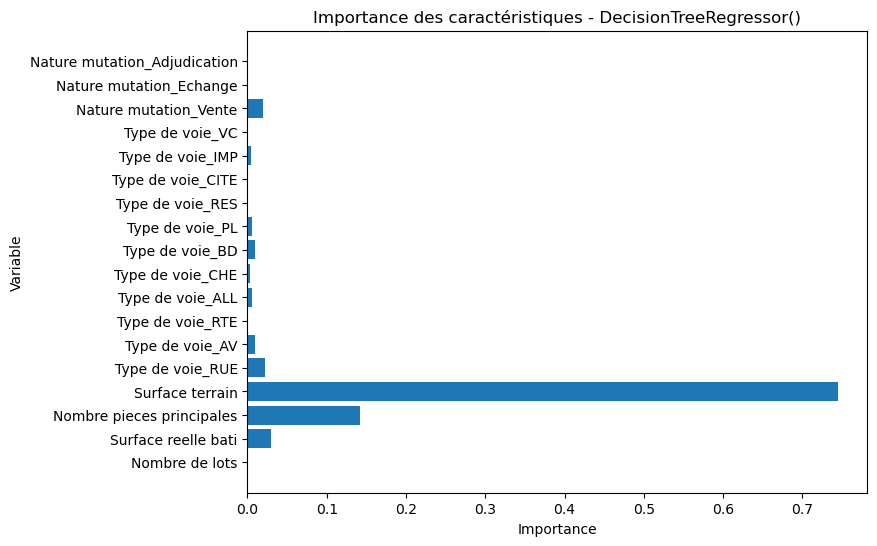

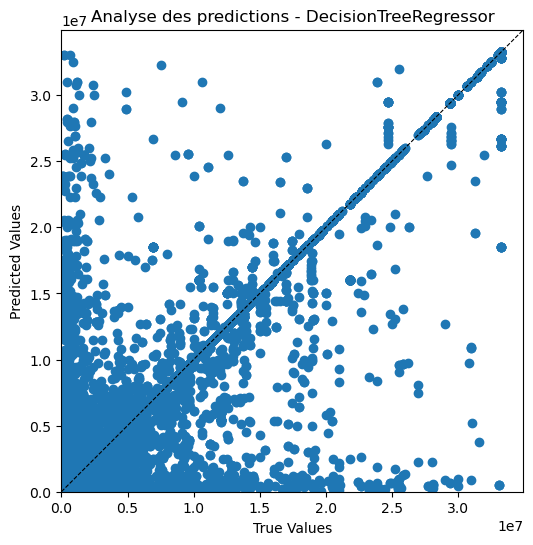

# RandomForestRegressor

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  ColumnTransformer(transformers=[('passthrough',
                                                                                   'passthrough',
                                                                                   ['Nombre '
                                                                                    'de '
                                                                                    'lots',
                                                                                    'Nombre '
                                                                                    'pieces '
                                                                                    'principales']),
                                                                                  ('scaler',
                                                                                   StandardScaler(),
                                                                                   ['Surface '
                                                                                    'reelle '
                                                                                    'bati',
                                                                                    'Surface '
                                                                                    'terrain'])]),
                                                  ['Nombre de lots',
                                                   'Surface reelle bati',
                                                   'Nombre pieces principales',
                                                   'Surface terrain']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(categories=[['RUE',
                                                                                              'AV',
                                                                                              'RTE',
                                                                                              'ALL',
                                                                                              'CHE',
                                                                                              'BD',
                                                                                              'PL',
                                                                                              'RES',
                                                                                              'CITE',
                                                                                              'IMP',
                                                                                              'VC'],
                                                                                             ['Vente',
                                                                                              'Echange',
                                                                                              'Adjudication']],
                                                                                 handle_unknown='ignore'))]),
                                                  ['Type de voie',
                                                   'Nature mutation'])])),
                ('regressor', RandomForestRegressor())])

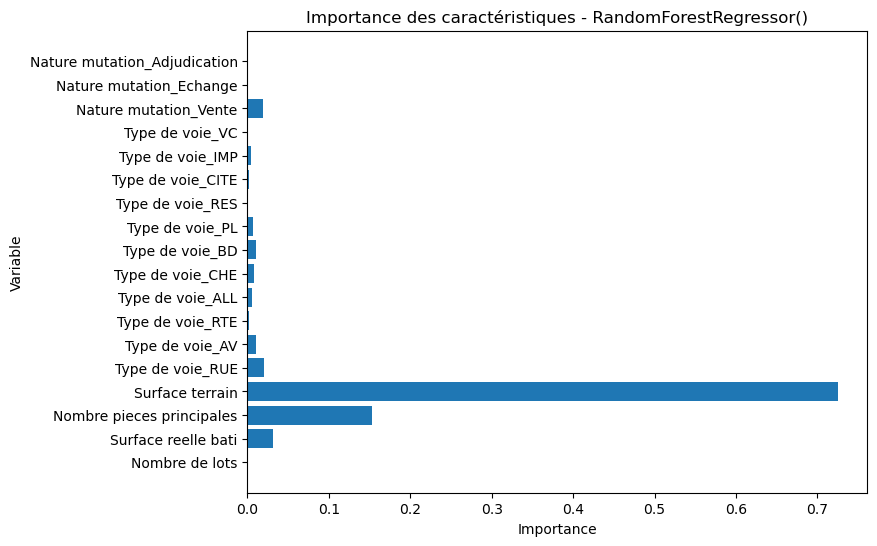

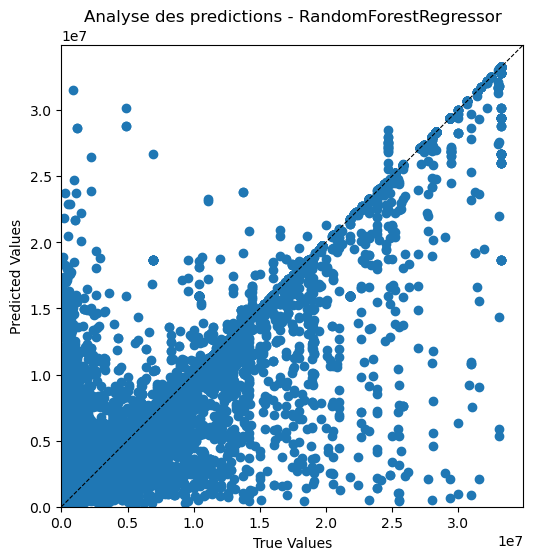

Regressor        R2          RMSE
0           LinearRegression  0.073734  7.484811e+06
1  GradientBoostingRegressor  0.406783  5.989902e+06
2      DecisionTreeRegressor  0.802016  3.460419e+06
3      RandomForestRegressor  0.863153  2.876940e+06

In [110]:
df_model = remove_outliers_iqr(df_model, 'Valeur fonciere')
run_regressors(df_model, regressors, preprocessor)

### 4.2.5) Optimisation de RandomForestRegressor

In [111]:


def optimize_model(regressor, df, preprocessor, param_grid, n_iter=100):
    # Création du pipeline avec le préprocesseur et le modèle de régression
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', regressor)
    ])

    # Définition des données
    X = df.drop('Valeur fonciere', axis=1)
    y = df['Valeur fonciere']

    # Séparation des données en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Configuration du modèle de recherche
    random_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=n_iter, cv=2, random_state=42, verbose=2)

    # Entraînement du modèle de recherche
    random_search.fit(X_train, y_train)

    # Affichage des meilleurs paramètres
    print(f"Meilleurs paramètres: {random_search.best_params_}")

    # Récupération du meilleur modèle
    best_model = random_search.best_estimator_

    # Prédiction des valeurs pour l'ensemble de test
    y_pred = best_model.predict(X_test)

    # Calcul du score R² et du RMSE pour l'ensemble de test
    r2 = r2_score(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    
    print()
    display(Markdown(f"## Score R² du meilleur modèle : {r2}"))
    display(Markdown(f"## RMSE du meilleur modèle : {rmse}"))
    plot_predictions(y_test, y_pred, random_search.best_estimator_)
    
    feature_importances = best_model.named_steps['regressor'].feature_importances_

    # Get feature names from the preprocessor steps
    num_cols_transformed = best_model.named_steps['preprocessor'].transformers_[0][2]
    cat_cols_transformed = best_model.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(cat_cols)

    feature_names = num_cols_transformed + cat_cols_transformed.tolist()



    plt.figure(figsize=(8, 6))
    plt.barh(feature_names, feature_importances)
    plt.xlabel('Importance')
    plt.ylabel('Variable')
    plt.title(f'Importance des caractéristiques - {regressor}')
    plt.show()

    return best_model

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] END regressor__bootstrap=True, regressor__max_depth=50, regressor__min_samples_leaf=4, regressor__min_samples_split=10, regressor__n_estimators=10; total time=   0.6s
[CV] END regressor__bootstrap=True, regressor__max_depth=50, regressor__min_samples_leaf=4, regressor__min_samples_split=10, regressor__n_estimators=10; total time=   0.6s
[CV] END regressor__bootstrap=True, regressor__max_depth=50, regressor__min_samples_leaf=1, regressor__min_samples_split=2, regressor__n_estimators=10; total time=   0.7s
[CV] END regressor__bootstrap=True, regressor__max_depth=50, regressor__min_samples_leaf=1, regressor__min_samples_split=2, regressor__n_estimators=10; total time=   0.7s
[CV] END regressor__bootstrap=True, regressor__max_depth=None, regressor__min_samples_leaf=1, regressor__min_samples_split=2, regressor__n_estimators=100; total time=   7.4s
[CV] END regressor__bootstrap=True, regressor__max_depth=None, regressor__min_s

## Score R² du meilleur modèle : 0.863569283141196

## RMSE du meilleur modèle : 2872560.3884356976

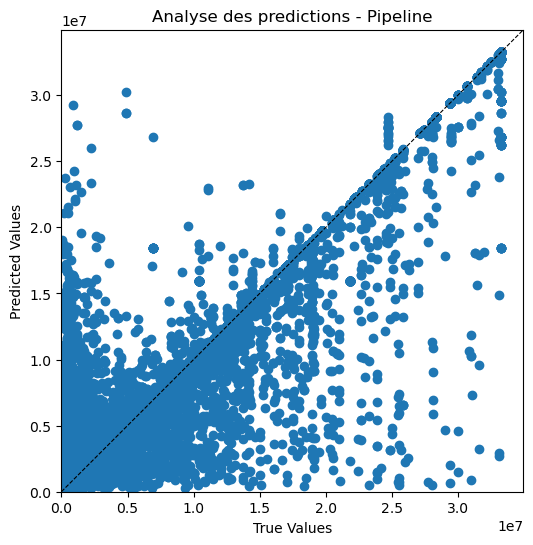

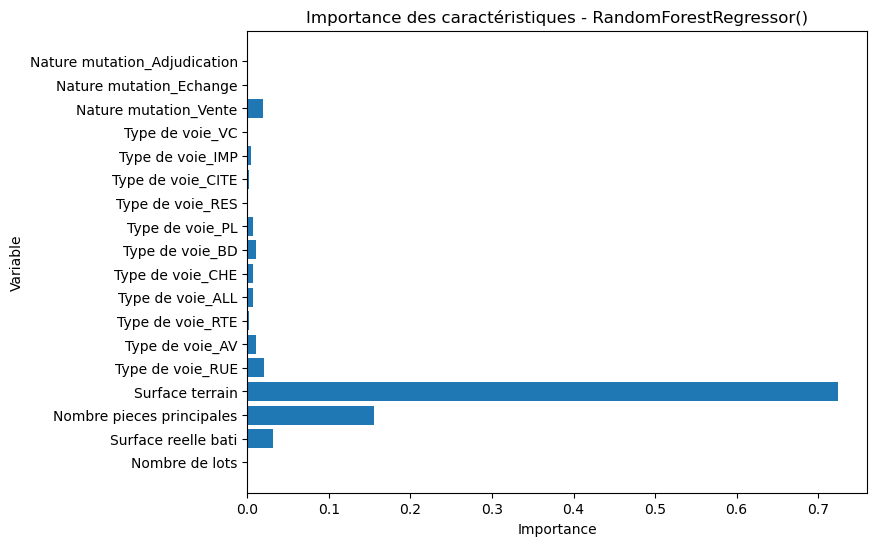

CPU times: total: 1min 4s
Wall time: 1min 8s


In [112]:
%%time
param_grid = {
    'regressor__n_estimators': [10, 50, 100],  # Nombre d'arbres dans la forêt
    'regressor__max_depth': [10, 20, 30, 40, 50, None],  # La profondeur maximale de l'arbre
    'regressor__min_samples_split': [2, 5, 10],  # Le nombre minimum d'échantillons requis pour diviser un noeud interne
    'regressor__min_samples_leaf': [1, 2, 4],  # Le nombre minimum d'échantillons requis pour être à un noeud feuille
    'regressor__bootstrap': [True, False]  # Méthode de sélection des échantillons pour la formation de chaque arbre
}



best_model = optimize_model(RandomForestRegressor(), df_model, preprocessor, param_grid, n_iter=10)


Le meilleur modele obtient un score R2 de 0.86 sur des donnes sur lequel il ne s'est pas entrainé. Cela veut dire que le modele interprete 86% de la variance de la valeur fonciere.

Nous pouvons analyser l'importance des caracterisitques pour connaitre les variables les plus liées a la valeur fonciere.
- La surface terrain est la caracteristiques la plus importantes pour predire la valeur fonciere
- Ensuite vient le nombre de pieces principales
- Puis la surface reelle bati
- Enfin le modele affine la valeur fonciere selon le type de voie. En particulier si c'est une Rue, une Allee, un chemin, un boulevard ou une place